**Table of contents**<a id='toc0_'></a>    
- 1. [Preprocessing](#toc1_)    
- 2. [Intro: A surprising plot!](#toc2_)    
  - 2.1. [Loading the Dataset](#toc2_1_)    
  - 2.2. [A Surprising Plot of Average Ratings Per Month Over Many Years](#toc2_2_)    
- 3. [Verifying Year-to-Year Seasonality: Are the Patterns Consistent?](#toc3_)    
  - 3.1. [Seasonality Metrics](#toc3_1_)    
- 4. [Pinpointing the Source: Seasonal Versus Year-Round Beers](#toc4_)    
  - 4.1. [New Metric and Beer Types --> are we still using this?](#toc4_1_)    
  - 4.2. [Seasonality in the Number of Ratings for different Beer Styles](#toc4_2_)    
  - 4.3. [Average Rating vs. Number of Ratings of Selected Beer Styles](#toc4_3_)
  - 4.4. [Identifying the most seasonal beers based on our metric](#toc4_4_)   
- 5. [Weather Influence](#toc5_)    
  - 5.1. [climatezone per country / state](#toc5_1_)    
  - 5.2. [Extracting weather data from excel files](#toc5_2_)    
  - 5.3. [Data Analysis](#toc5_3_)    
  - 5.4. [Descriptive Statistics for Weather Data](#toc5_4_)    
  - 5.5. [Correlation Analysis Between Weather and Beer ratings](#toc5_5_)
  - 5.6. [Clustering Analysis](#toc5_6_)
  - 5.7. [Mutual Information (MI) between variables](#toc5_7_)
  - 5.8. [Conclusion: Analysis of Weather Effects on Beer Ratings](#toc5_8_)
- 6. [Conclusion](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as py

from statsmodels.tsa.seasonal import STL

py.init_notebook_mode(connected=True)

sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from src.utils.locationHelper import LocationHelper
from src.utils.preProcessingHelper import PreProcessRatings
import src.utils.preProcessingHelper as preProcessingHelper
from src.utils.jeanneHelper import JeanneHelper, get_rating_per_month
import src.utils.seasonalityMetrics as sm 

helper = JeanneHelper()

from pandas.api.types import CategoricalDtype

import scipy.stats as stats
from scipy.stats import  kruskal, anderson, shapiro
import random

import src.utils.USClimateAndWeatherHelper as WaH
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(42)

Note: The graphics that we created with plotly won't show on git. We saved all of them in illustrations in the defined folder.

# 1. <a id='toc1_'></a>[Preprocessing](#toc0_)
### Which data should we use for our investigation?

For this project, we used BeerAdvocate data, focusing on US-based reviews from 2002 to 2017 to ensure we had enough consistent data. 
We looked at key details a rating scores, timestamps, user locations, and beer styles. 

For the preprocessing we've written a [preProcessingHelper.py](src/utils/preProcessingHelper.py). We have a jupyter notebook [preProcessing.ipynb](test/preProcessing.ipynb) which shows our workflow to eventually get the preProcessingHelper.py


Additionally we've written a [locationHelper.py](src/utils/locationHelper.py), which adds the country and state codes to the reviews. For the part of the analysis that needs a corresponding location to the review, we assume that the location of the user that wrote the review is most likely the location where the review was written. If there is still time after our main tasks, this is something we could investigate further.

In [230]:
pp = PreProcessRatings(platform="BeerAdvocate")
df = pp.get_dataframe(dataset="both", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style", "beer_name", "beer_id"])
df.to_csv("src/data/beerAdvocateRatingsBothDatasets.csv")

start parsing the beer reviews for BeerAdvocate
finished parsing the beer reviews for BeerAdvocate with direct conversion
now you can get dataframes with the "get_dataframe" handle
Country svalbard and jan mayen islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country aotearoa could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country fiji islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country heard and mcdonald islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country south georgia and south sandwich islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
From 8393032 reviews, 7892754 have a location (corresponding to the user) and 500278 do not have a location


In [231]:
both_df = pd.read_csv("src/data/beerAdvocateRatingsBothDatasets.csv", index_col=0) # dataset containing reviews and ratings

In [232]:
both_df.head()

rating  is_review    country_name country_code3       state  \
0    2.88       True   United States           USA  Washington   
1    3.67       True   United States           USA    New York   
2    3.73       True  United Kingdom           GBR         NaN   
3    3.98       True  United Kingdom           GBR         NaN   
4    4.00       True  United Kingdom           GBR         NaN   

           date_object  month  year             style      beer_name  beer_id  
0  2015-08-20 12:00:00      8  2015   Euro Pale Lager          Régab   142544  
1  2009-02-20 12:00:00      2  2009  English Pale Ale  Barelegs Brew    19590  
2  2006-03-13 12:00:00      3  2006  English Pale Ale  Barelegs Brew    19590  
3  2004-12-01 12:00:00     12  2004  English Pale Ale  Barelegs Brew    19590  
4  2004-08-30 12:00:00      8  2004  English Pale Ale  Barelegs Brew    19590

To make things easier and more robust to changes differences of rating systems that are eventually reflected in the rating, we took the decision to do our investigation for only one platform (and maybe do it for the other platform depending on how much time is left in the end of the project). As BeerAdvocate has more data compared to RateBeer and has more fine grained data, we concluded to go for BeerAdvocate in the US. BeerAdvocates data mainly stems from the US, which we can see on the map down below. Aditionally, we have a further partitioning in the states

In [ ]:
ratings_count = both_df.groupby("country_code3").agg(nr_ratings=("country_code3", "count")).reset_index()
ratings_count["nr_ratings_log"] = np.log2(ratings_count["nr_ratings"]).replace(-np.inf, 0)

country_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
map = folium.Map(location=[10, 0], zoom_start=1.5)
cp = folium.Choropleth(geo_data=country_geo,
            data=ratings_count,
            columns=['country_code3', 'nr_ratings_log'],
            key_on='feature.id',
            fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
            legend_name="Nr. of ratings (log2 scale)",
            highlight=True

        ).add_to(map)

for s in cp.geojson.data['features']:
      if s['id'] in ratings_count['country_code3'].values:
            s['properties']['nr_ratings'] = (ratings_count[ratings_count["country_code3"] == s['id']]["nr_ratings"]).values[0].astype(str)
      else:
            s['properties']['nr_ratings'] = "0"
      
folium.GeoJsonTooltip(['name', "nr_ratings"]).add_to(cp.geojson)
folium.LayerControl().add_to(map)

map.save("illustrations/Tim/nr_ratings_BeerAdvocate.html")

map

In [ ]:
# reduce our dataframe to data from US
both_df = both_df[both_df["country_code3"] == "USA"]

### Can we find special behaviour for some year?

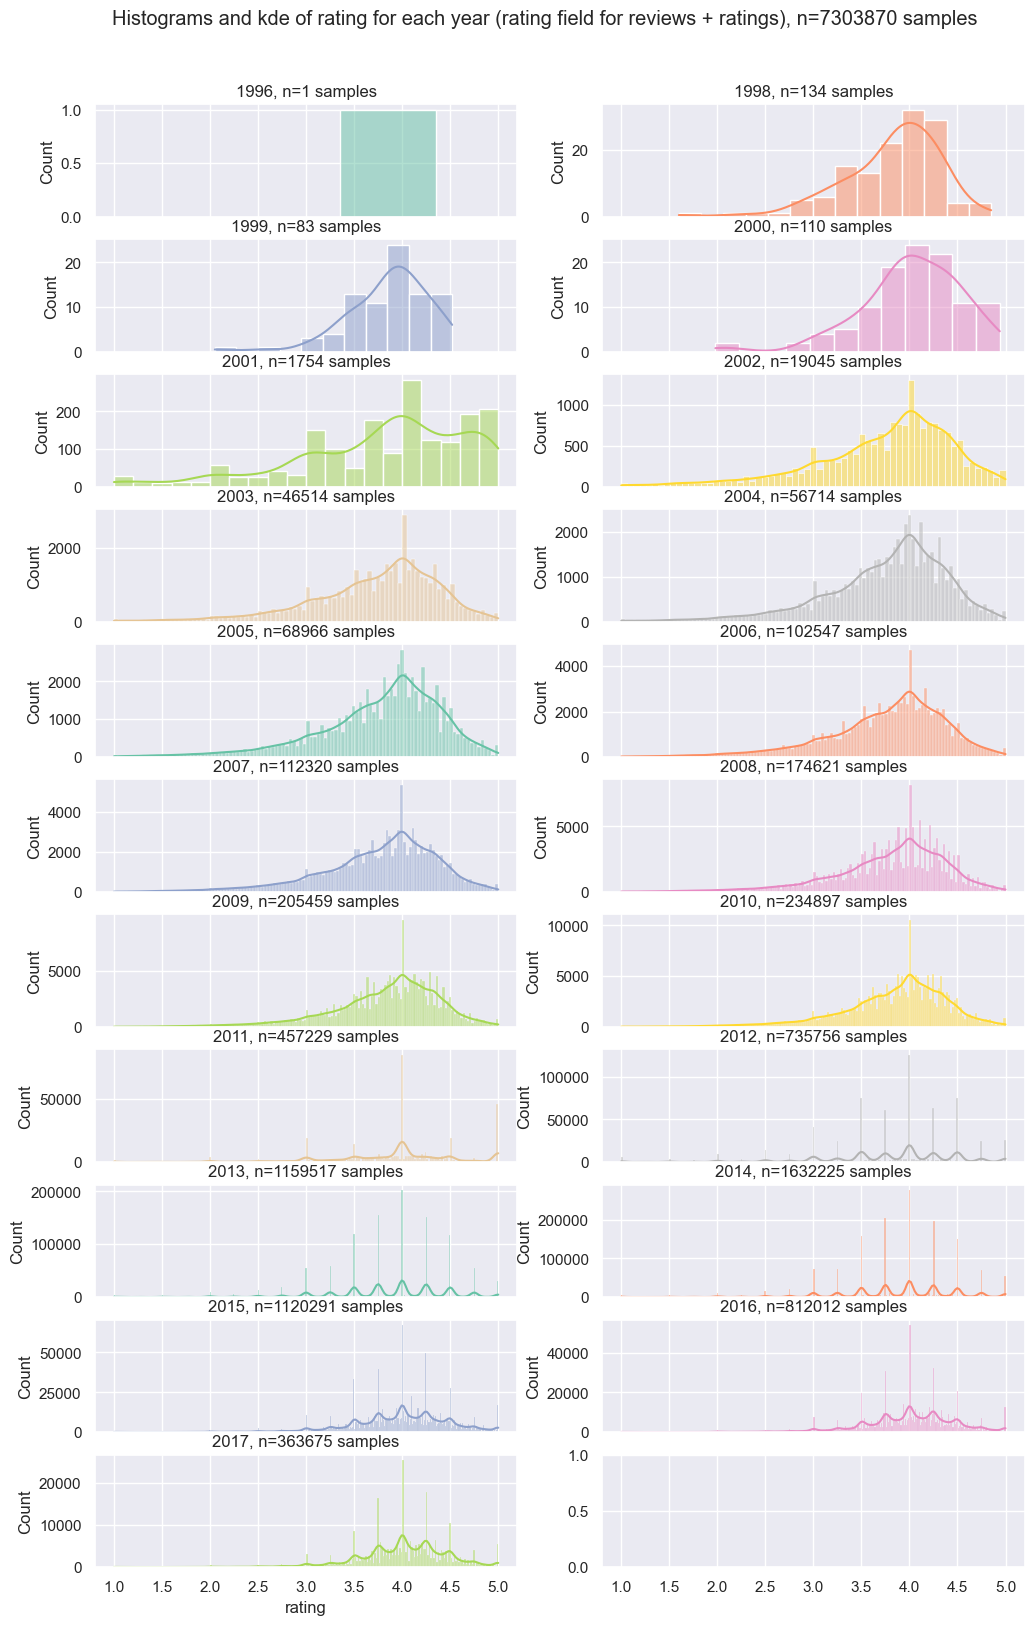

In [4]:
years = np.sort(both_df["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 19), sharex=True)
ax = ax.flatten()
fig.suptitle(f"Histograms and kde of rating for each year (rating field for reviews + ratings), n={both_df.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = both_df[both_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i], color=palette[i%len(palette)])
    h.set_title(f'{int(year)}, n={year_df.shape[0]} samples')

In [37]:
# same with plotly
fig = px.histogram(both_df, x="rating", color="is_review", barmode="overlay", facet_row="year",
                   labels={"is_review": "Review", "rating": "Nr Ratings/Reviews"},
                   title="Nr of Reviews and Nr of Ratings per year"
                   )
fig.write_html("illustrations/Tim/histReviewsAndRatingsPerYear.html")

In [36]:

df = both_df.groupby(["year", "is_review"])["rating"].agg("count").reset_index()
fig = px.bar(df, x="year", y="rating", color="is_review", barmode="overlay",
                   labels={"is_review": "Review", "rating": "Nr Ratings/Reviews"},
                   title="Nr of Reviews and Nr of Ratings per year"
                   )

# fig.update_traces(opacity=0.5, marker_color="red", selector=dict(name="True")) 
# fig.update_traces(opacity=1, marker_color="blue", selector=dict(name="False"))
fig.write_html("illustrations/Tim/histNrReviewsVsRatings.html")
fig.show()


Looking at the plots we see that starting from 2002 the number of ratings start to rise and is more similar to the other years. We conclude that most likely the rating system changed as well. To not let old data screw our results, we get rid of the data before 2002.

In [5]:
both_df = both_df[both_df["year"] >= 2002]
reviews_df = both_df[both_df["is_review"]]
ratings_df = both_df[~both_df["is_review"]]

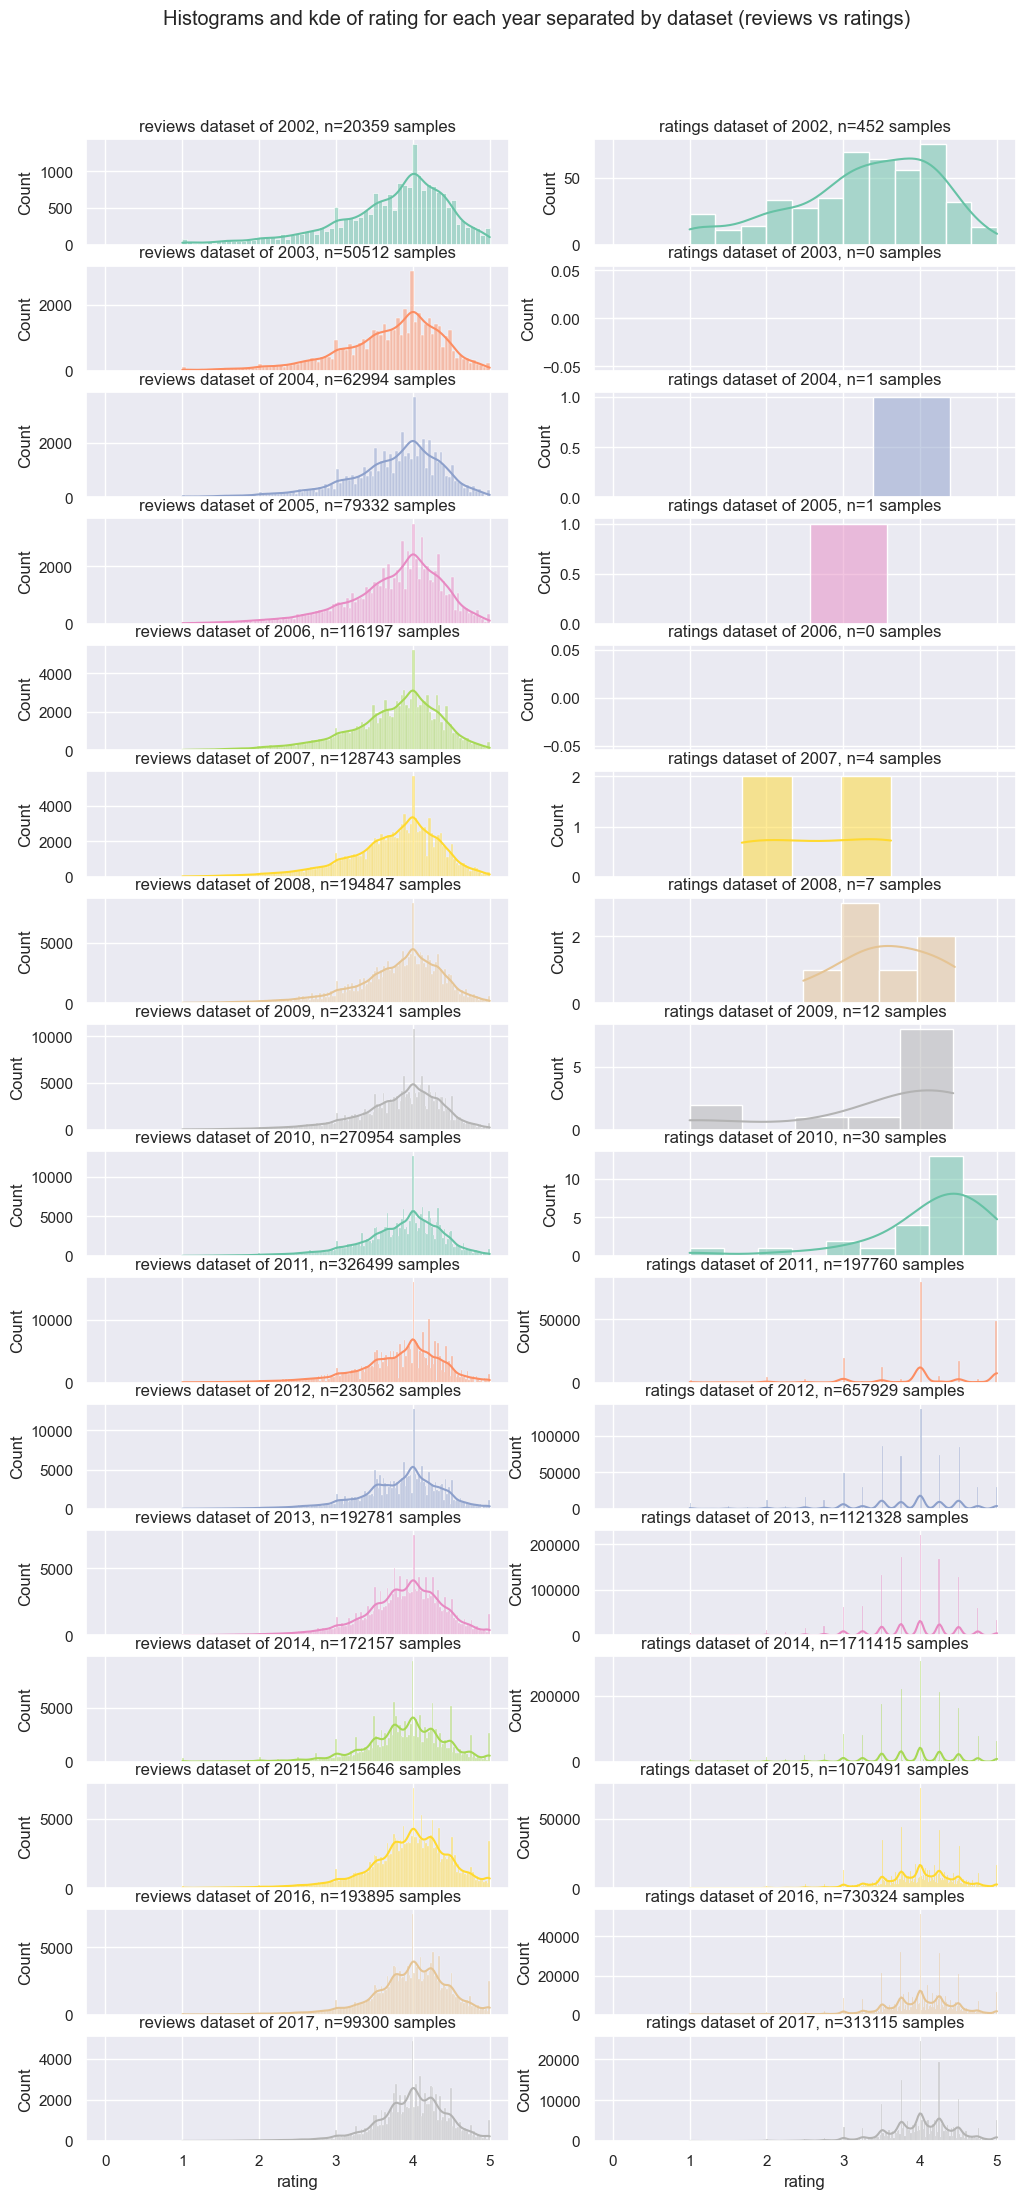

In [40]:
years = np.sort(reviews_df["year"].dropna().unique())
fig, ax = plt.subplots(int(len(years)), 2, figsize= (12, 26), sharex=True)

fig.suptitle(f"Histograms and kde of rating for each year separated by dataset (reviews vs ratings)", y=0.93)

# reviews
for i, year in enumerate(years):
    year_df = reviews_df[reviews_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i][0], color=palette[i%len(palette)])
    h.set_title(f'reviews dataset of {int(year)}, n={year_df.shape[0]} samples')

# reviews
for i, year in enumerate(years):
    year_df = ratings_df[ratings_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i][1], color=palette[i%len(palette)])
    h.set_title(f'ratings dataset of {int(year)}, n={year_df.shape[0]} samples')

Furthermore, there are two datasets: ratings and reviews. We conclude that these are two ways how people can record a beer review. Both datasets have a rating attribute $r \in [1, 5]$, which reflects the quality of a beer.
- In the reviews dataset, $r$ is calculated as a weighted mean over different attributes.
- In the rating dataset, $r$ is a continuous number (from 2011-2014, $r$ was discrete with steps of 0.25).

Until 2011, there were more reviews than ratings. From 2011 to 2017 there are a lot more ratings than reviews. We conclude to work with data from **the reviews dataset**. It's less data but, more importantly, it's more balanced over the years.

In [ ]:
# plot for reducement of the dataset
both_df = pd.read_csv("src/data/beerAdvocateRatingsBothDatasets.csv", index_col=0) # dataset containing reviews and ratings
lenArr = []
lenArr.append(len(both_df))

both_df = both_df[both_df["country_code3"] == "USA"]
lenArr.append(len(both_df))

reviews_df = both_df[both_df["is_review"]]
lenArr.append(len(reviews_df))

reviews_df = reviews_df[reviews_df["year"] >= 2002]
lenArr.append(len(reviews_df))


data = dict(
    number=lenArr,
    stage=["BeerAdvocate", "Only USA", "only Reviews", ">=2002"])
fig = px.funnel(data, x='number', y='stage', title= "Reduction in Size of our Dataset")

fig.write_html("illustrations/Tim/funnelSizeReductionDataset.html")
fig.show()

# 2. <a id='toc2_'></a>[Intro: A surprising plot!](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Loading the Dataset](#toc0_)

In [5]:
ph = PreProcessRatings(platform="BeerAdvocate")
reviews_df = ph.get_dataframe(dataset="reviews", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style"])
reviews_df.to_csv("src/data/beerAdvocateReviews.csv", index=False)

start parsing the beer reviews for BeerAdvocate
finished parsing the beer reviews for BeerAdvocate with direct conversion
now you can get dataframes with the "get_dataframe" handle
Country svalbard and jan mayen islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country aotearoa could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country fiji islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country south georgia and south sandwich islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
From 2589586 reviews, 2494478 have a location (corresponding to the user) and 95108 do not have a location


KeyboardInterrupt: 

In [ ]:
reviews_df = pd.read_csv("src/data/beerAdvocateReviews.csv") # dataset containing reviews
reviews_df = reviews_df[(reviews_df["year"] >= 2002) & (reviews_df["country_code3"] >= "USA")]

In [17]:
reviews_df = pd.read_csv(r"src/data/beerAdvocateReviewsUSA.csv")


## 2.2. <a id='toc2_2_'></a>[A Surprising Plot of Average Ratings Per Month Over Many Years](#toc0_)

The following plot displays the average ratings for all beers across every month from multiple years, based on over two million ratings. 

For example, the value for month 6 represents the average rating for all June months between 2002 and 2017. 

This plot, referred to as the "Main Average Rating Plot," appears to show fluctuations in beer ratings throughout the year.

In [32]:
fig = sm.plot_average_over_years(reviews_df)
fig.show()
#fig.write_html('src/plotly-html-graphs/jakob/MainSeasonalNarrow.html')
print(f'Avg rating in the US over the period {reviews_df["year"].min()} - {reviews_df["year"].max()} with 95% confidence interval, n={reviews_df.shape[0]}')

Avg rating in the US over the period 2002 - 2017 with 95% confidence interval, n=2239823


But why could this be the case? In this project, our goal is to investigate the underlying reasons for this apparent seasonal behavior in beer ratings. 

Specifically, we seek to answer several key questions:
- Is this pattern driven by consistent year-to-year effects, or are the fluctuations merely the result of outliers or a few exceptionally strong years distorting the average?
- Is there a particular subset of beers responsible for these seasonal variations? 
- Could factors like climate or weather influence these rating trends?

Through careful analysis, we aim to uncover the reasons behind the observed seasonal behavior in beer ratings and provide a deeper understanding of the trends reflected in the Main Average Rating Plot.

Anderson-Darling test to check for normality for month 1:
AndersonResult(statistic=np.float64(2746.054774901422), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.8606827589862713), scale=np.float64(0.5972202352409599))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test to check for normality for month 2:
AndersonResult(statistic=np.float64(2506.722981902567), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.862817498203195), scale=np.float64(0.5954146412276019))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test to check for normality for month 3:
AndersonResult(statistic=np.float64(2674.223614056624), critical_values=array([0.576, 0.656, 0.

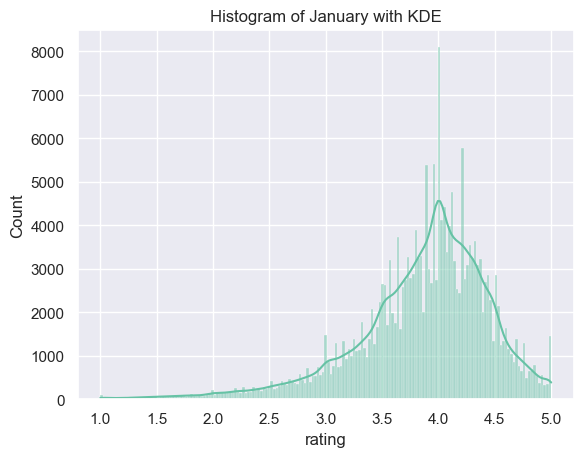

In [ ]:
monthly_ratings = get_rating_per_month(reviews_df)
h = sns.histplot(monthly_ratings[0], kde=True)
h.set_title("Histogram of January with KDE")
h.set_xlabel("rating")

for i, ratings in enumerate(monthly_ratings):
    print(f"Anderson-Darling test to check for normality for month {i+1}:")
    print(anderson(ratings, dist="norm"))
    print()

 We aim to determine if this variation is statistically significant. 

First, we test whether we can assume normality in the data.

 Given the large sample size, we chose the Anderson-Darling Test over the Shapiro-Wilk Test to assess normality. We can see that, for each month, the statistics exceeds the critical value by far (for each significance level). 
 
 Therefore we'll reject the null hypothesis and don't assume normality which is not surprising by looking at the histogram for the ratings of january. 

Our dependent variable is the rating of the beer and our indepenent variable is the month. We want to assess the differences between groups on a continuous measurement (rating) with only one, categorical independent variable (month). As we can't assume normality, we choose Kruskal_Wallis H-Test, which is a non-parametric version of ANOVA.

$H_0:$ The means of the ratings for all the months are equal. 


$H_A:$ At least one mean of the ratings for a month is different from the rest.

In [ ]:
kruskal(*monthly_ratings)

KruskalResult(statistic=np.float64(1382.6589352461285), pvalue=np.float64(6.637202926990672e-290))

As the p-value is 0.0 < 0.05, we can reject $H_0$. It's very likely that at least one mean of the ratings over the months is different.


Where does this difference come from? Are there people that are easier on the ratings for beers for some seasons compared to others? This is what we try to understand in the next sections.

# 3. <a id='toc3_'></a>[Verifying Year-to-Year Seasonality: Are the Patterns Consistent?](#toc0_)

To determine whether the observed seasonality across years is due to a consistent annual pattern rather than outliers or singular dominant years skewing the mean. 

First, we preprocess the data using STL decomposition. STL (Seasonal and Trend decomposition using Loess) separates the seasonal component from the underlying trend and residual (noise) in the monthly rating averages. We use STL decomposition to extract the seasonal component by removing the trend and noise, thus making the signal clearer for further analysis. STL is particularly effective because it is resilient to outliers, handles missing data, and reduces noise [(Arneric, 2021)](https://doi.org/10.17535/crorr.2021.0006). Below, a plot containing the results from STL decomposition of average ratings is shown.

After extracting the seasonal component with STL, we apply the Fourier transform to identify dominant frequencies. If the dominant period is 12 months, this confirms that the average rating pattern is yearly seasonal .

In [6]:
# import helper and loading the data
df_reviews = pd.read_csv(r"src/data/beerAdvocateReviewsUSA.csv")

In [8]:
df_processed_mean = sm.data_preprocessing_mean_rating_per_month(df_reviews, 'mean_rating')
sm.STL_plot(df_processed_mean)

Below the results are shown for the Fourier analysis of the seasonal component of the STL.

In [ ]:
## STL and Fourier Analysis

"""

 1) preps the raw ratings data (take averages over all mnths and turns it into a proper timeseries)
 2) splitting timeseries into seasonal and non-seasonal components
 3) gives a seasonality amplitude score based on only the seasonal component
 4) returns frequency specrum of the seasonal signal, to verify 12-month periodicity

 """
df_processed_mean = sm.data_preprocessing_mean_rating_per_month(df_reviews, 'mean_rating') # evaluates based on average of rating score
fig_seasonality_full = sm.seasonality_report_plot(df_processed_mean, unit= "Average Rating", title = "Seasonality Report - Average Ratings of All Beers", top_margin=100) # 
fig_seasonality_full.show()
#fig_seasonality_full.write_html('src/plotly-html-graphs/jakob/seasonality_full.html')

print("Signal-to-Noise  Ratio of 12-month seasonality: ", sm.signal_to_noise_ratio(df_processed_mean), " dB")

(188, 1)


Signal-to-Noise  Ratio of 12-month seasonality:  21.3482  dB


The Fourier transform of the signal shows a dominant frequency of 0.085 $\text{months}^{-1}$, corresponding to a period of 11.75 months. Since the discrete Fourier transform does not evaluate 0.083 $\text{months}^{-1}$ (the exact 12-month period), 0.085 is the closest match.

We calculate the Signal-to-Noise Ratio (SNR) to determine the strength of the observed yearly pattern relative to random noise, providing a quantitative measure of signal reliability. SNR is particularly useful because it has well-defined thresholds that help distinguish meaningful patterns from noise. According to a NumXL article on data analysis, an SNR between 10 and 15 dB typically indicates a strong, reliable signal.

While any SNR > 0 dB shows that the signal is stronger than the noise floor, we adopt a cutoff of 10 dB to confirm seasonality, following NumXL's (2020) [guidelines](https://support.numxl.com/hc/en-us/articles/360050017731-Calculating-Signal-to-Noise-Ratio-Using-DFT) for calculating SNR using the Discrete Fourier Transform (DFT). The calculated SNR of 21.3 dB for the signal indicates that the 12-month peak is highly significant, strongly suggesting that the average ratings are influenced by consistent year-to-year effects.

## 3.1. <a id='toc3_1_'></a>[Seasonality Metrics](#toc0_)

To better understand the observed trends and identify whether a specific subset of beers is driving the seasonality, we introduce two metrics: **peak_ratio** and **mean_amplitude**. These metrics are designed to quantify and compare the strength and significance of seasonality across different beer subsets.

**Peak Ratio**: This metric ensures the signal is primarily driven by a 12-month periodicity rather than random noise or other dominant frequencies. By calculating the ratio of the 12-month peak to the second-largest peak, we can assess the significance of the 12-month period. A large ratio indicates that the 12-month signal stands out as the dominant periodicity, confirming meaningful seasonality.

**Mean Amplitude**: This metric measures the overall strength of the seasonal signal across the entire period. By calculating the amplitude of the seasonal component for each period and taking the average, we can compare the intensity of seasonality between subsets. This helps highlight how strongly a subset's ratings fluctuate seasonally.

<img src="assets/img/metric_explanation_1.png" width="600"/>



# 4. <a id='toc4_'></a>[Pinpointing the Source: Seasonal Versus Year-Round Beers](#toc0_)

## 4.1. <a id='toc4_1_'></a>[New Metric and Beer Types --> are we still using this?](#toc0_)

To measure seasonality in beer ratings, we wanted to define a clear and meaningful metric. We introduced the *Seasonality Score, calculated as the difference between the **mean summer rating* (June to August) and the *mean winter rating* (December to February). This score captures how beer ratings shift between the warmer and colder seasons.

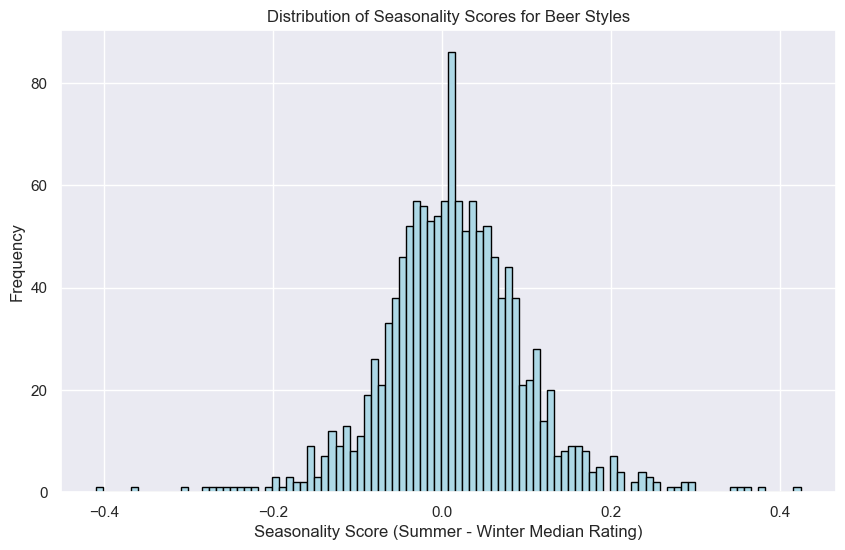

In [ ]:
seasonality_scores = helper.calculate_seasonality_score_by_style(df_reviews, min_reviews=100)

plt.figure(figsize=(10, 6))
plt.hist(seasonality_scores['Seasonality_Score'], bins=100, color='lightblue', edgecolor='black')
plt.xlabel('Seasonality Score (Summer - Winter Median Rating)')
plt.ylabel('Frequency')
plt.title('Distribution of Seasonality Scores for Beer Styles')
plt.show()

#### Test if Data is Normally Distributed

After calculating the seasonality score for our dataset, we performed a **Shapiro-Wilk Test** to test for normality. The resulting p-value was extremely small (6.3e-16), which is far below the typical significance level of 0.05. This indicates that we **reject the null hypothesis (H₀)**, meaning that the data does **not** follow a normal distribution.

However, since we have a sample size of **1278**, we can invoke the **Central Limit Theorem (CLT)**. The CLT states that for sufficiently large sample sizes, the distribution of the sample mean will approximate a normal distribution, regardless of the underlying distribution of the data. Given the large sample size, we can reasonably assume that the sample mean will be normally distributed, allowing us to proceed with statistical analysis that assumes normality.

In [ ]:
stat, p_value = stats.shapiro(seasonality_scores['Seasonality_Score'])
print(f"Shapiro-Wilk Test: p-value = {p_value}")

if p_value > 0.05:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

Shapiro-Wilk Test: p-value = 7.521329216201117e-15
Data does not look normally distributed (reject H0)


In [ ]:
len(seasonality_scores['Seasonality_Score'])

1315

#### Determine if the Mean is Significantly Different from Zero
The mean seasonality score is slightly positive, indicating higher beer ratings in summer compared to winter, while the median is close to the mean, suggesting a relatively symmetric distribution. The skewness of 0.402 indicates a mild positive skew, meaning a few higher values are pulling the distribution to the right.

A one-sample t-test was conducted to test if the mean seasonality score is significantly different from zero. The results showed a very low p-value, allowing us to reject the null hypothesis and conclude that the mean seasonality score is significantly different from zero. This confirms that, on average, beer ratings in summer are higher than in winter.

In [21]:
mean_score = seasonality_scores['Seasonality_Score'].mean()
median_score = seasonality_scores['Seasonality_Score'].median()
skewness_score = stats.skew(seasonality_scores['Seasonality_Score'].dropna())

print("Mean Seasonality Score:", mean_score)
print("Median Seasonality Score:", median_score)
print("Skewness of Seasonality Score:", skewness_score)

Mean Seasonality Score: 0.014627834110268028
Median Seasonality Score: 0.011753803379622951
Skewness of Seasonality Score: 0.16434158695981183


In [ ]:
t_stat, p_value = stats.ttest_1samp(seasonality_scores['Seasonality_Score'], 0)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: The mean seasonality score is significantly different from zero.")
else:
    print("Fail to reject the null hypothesis: The mean seasonality score is not significantly different from zero.")

T-statistic: 6.323685261196697
P-value: 3.4927665236397137e-10
Reject the null hypothesis: The mean seasonality score is significantly different from zero.


## 4.2. <a id='toc4_2_'></a>[Seasonality in the Number of Ratings for different Beer Styles](#toc0_)
We defined the Number of Ratings of a beer style as the count of ratings it recieved n a given months.

To examine seasonal trends, we analyzed the top 10 most frequently rated beer styles each month, identifying those that appeared only during specific periods and those that remained consistently in the top ranks.  

As shown in the plot "Top 10 Beer Styles by Number of Reviews per Month (Grouped by Season)" below, certain beer styles appear only during specific periods, such as Pumpkin Ale in the fall, Fruit and Vegetable beers in late spring and summer, Märzen/Oktoberfest beers in September and October, and Winter Warmer in December.  

Other beer styles appear to maintain consistent popularity throughout the year. American IPA is the most rated beer type each month, with American Double/Imperial IPA consistently in second place. Saison/Farmhouse Ale tends to occupy a middle position, while American Amber/Red Ale often ranks near the bottom of the set.  

In [ ]:
# Load data
df_reviews = pd.read_csv('src/data/beerAdvocateReviewsUSA.csv')

In [12]:
top_styles_per_month_percentage = helper.top_k_beer_styles_percentage(df = df, k = 10, group_by = 'month')
top_styles_per_month_percentage.head()

month                             style  rating_count  total_ratings  \
0      1                      American IPA         18626         207442   
1      1    American Double / Imperial IPA         14424         207442   
2      1  American Double / Imperial Stout         11698         207442   
3      1            Russian Imperial Stout          8186         207442   
4      1           American Pale Ale (APA)          7838         207442   

   percentage  
0    8.978895  
1    6.953269  
2    5.639167  
3    3.946163  
4    3.778406

In the plot below, we can observe the top 10 beer styles the most frequently reviewed for each month, as the percentage of the total ratings of that specific month. 

We can observe that certain beer styles appear only during specific periods, such as Pumpkin Ale in the fall, Fruit and Vegetable beers in late spring and summer, Märzen/Oktoberfest beers in September and October, and Winter Warmer in December.   

Other beer styles appear to maintain numbers of ratings throughout the year. American IPA is the most rated beer type each month, with American Double/Imperial IPA consistently in second place. Saison/Farmhouse Ale tends to occupy a middle position, while American Amber/Red Ale often ranks near the bottom of the set.  

In [13]:
top_styles_per_month_percentage_sorted = top_styles_per_month_percentage.sort_values(by=['month', 'percentage'], ascending=[True, False])

unique_styles = top_styles_per_month_percentage['style'].unique()
palette = sns.color_palette("tab20", len(unique_styles)).as_hex()
style_colors = dict(zip(unique_styles, palette))

# Uncomment the category_orders dictionary
category_orders = {
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    #'style': top_styles_list
}

frames = [go.Frame(
    data=[go.Bar(
        x=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == month]['percentage'],
        y=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == month]['style'],
        orientation='h',
        marker_color=[style_colors[x] for x in top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == month]['style'].to_list()],
    )],
    name=str(month),
) for month in category_orders['month']]

fig = go.Figure(
    data=[go.Bar(
        x=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == 1]['percentage'],
        y=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == 1]['style'],
        orientation='h',
        marker_color=[style_colors[x] for x in top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == 1]['style'].to_list()],
    )],
    layout=go.Layout(
        title="Top Beer Styles by Percentage of Reviews per Month",
        xaxis=dict(title="Percentage of Ratings"),
        yaxis=dict(title="Beer Style", automargin=True),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=1, redraw=True), fromcurrent=True)])],
            x=1.15,  # Position the button on the top right
            xanchor='right',
            y=1.15,
            yanchor='top'
        )],
        sliders=[{
            'steps': [
                {'args': [
                    [str(month)],
                    {'frame': {'duration': 1, 'redraw': True}, 'mode': 'immediate'}
                ],
                'label': str(month),
                'method': 'animate'} for month in category_orders['month']
            ],
            'transition': {'duration': 1},
            'x': 0.1,
            'len': 0.9,
            'currentvalue': {
                'prefix': 'month: ',
                'font': {'size': 20, 'color': '#666'}
            }
        }]
    ),
    frames=frames
)
fig.show()
fig.write_html("illustrations/Jeanne/top_styles_per_month_percentage.html")

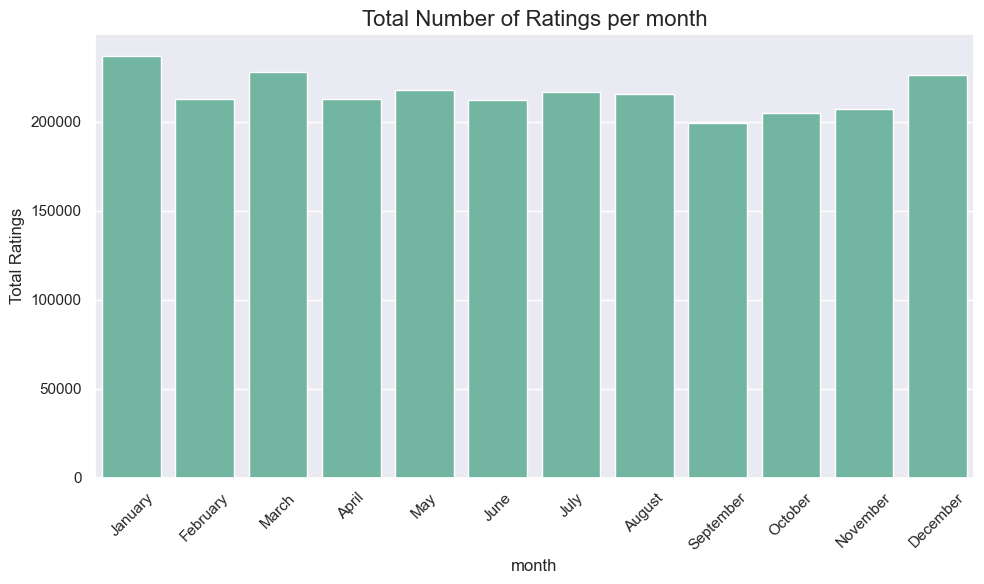

In [ ]:
total_ratings_per_month = reviews_df.groupby('month').size().reset_index(name='rating_count')

total_ratings_per_month = total_ratings_per_month.sort_values(by='month')

plt.figure(figsize=(10, 6))
sns.barplot(data=total_ratings_per_month, x='month', y='rating_count')

plt.title('Total Number of Ratings per month', fontsize=16)
plt.xlabel('month', fontsize=12)
plt.ylabel('Total Ratings', fontsize=12)
plt.xticks(ticks=range(12), labels=[pd.to_datetime(f'2023-{month:02d}-01').strftime('%B') for month in range(1, 13)], rotation=45)
plt.tight_layout()
plt.show()


## 4.3. <a id='toc4_3_'></a>[Average Rating vs. Number of Ratings of Selected Beer Styles](#toc0_)

We chose the following beer styles for analysis based on their patterns of Numbers of Ratings:

- **Seasonal Beers**: **Fruit/Vegetable Beer**, **Pumpkin Ale**, and **Winter Warmer** are considered seasonal because they are popular only during specific periods of the year.
- **Unseasonal Beers**: **American IPA**, **Saison/Farmhouse Ale**, and **American Amber/Red Ale** are considered unseasonal, as they maintain consistent popularity throughout the year.

For each of these beer types, we computed the following metrics:
- **Number of Ratings per Month** for both seasonal and unseasonal beers.
- **Percentage of Ratings per Month** for each style within its category.
- **Average Rating per Month** for the selected beer styles.

This analysis revealed some interesting patterns that warrant further investigation. For example, we could refine the analysis by identifying a subset of beers with high seasonality and excluding beers with high popularity and large deviations from the average rating. These **impactful beers**, which have high popularity during specific periods and significant variability in their ratings, may offer deeper insights into the dynamics of seasonal trends.


In [30]:
# Chose the beer styles with interessant features
beer_styles = [
    'Fruit / Vegetable Beer', 'Pumpkin Ale', 'Winter Warmer',  # Seasonal beers
    'American IPA', 'Saison / Farmhouse Ale', 'American Amber / Red Ale'  # Unseasonal beers
]

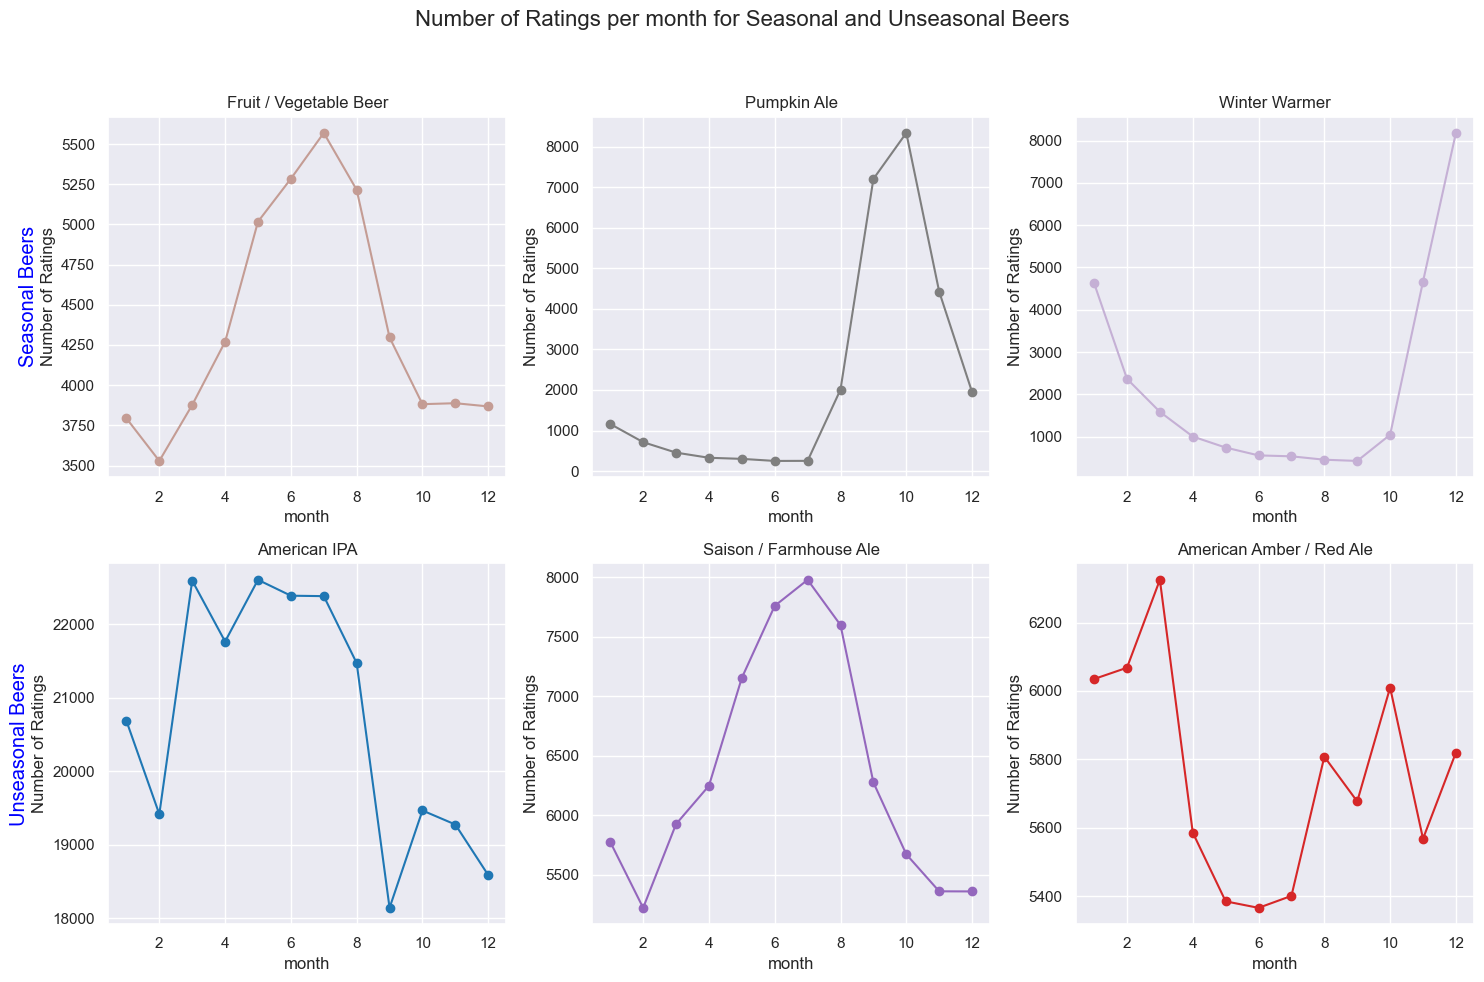

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Number of Ratings per month for Seasonal and Unseasonal Beers', fontsize=16)

categories = ['Seasonal Beers', 'Unseasonal Beers']

# Loop over each beer style and corresponding subplot for the number of ratings
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    # Filter DataFrame for the current style
    style_df = reviews_df[reviews_df['style'] == style]
    
    # Group by month and count the number of ratings
    monthly_counts = style_df.groupby('month').size()
    
    # Plot the monthly counts on the current subplot
    ax.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color=style_colors[style])
    ax.set_title(style)
    ax.set_xlabel('month')
    ax.set_ylabel('Number of Ratings')
    
    # Add the category label on the left of each row
    if idx % 3 == 0:  # Only add the label on the first column of each row
        row_label = categories[idx // 3]
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90, color='blue')
        
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

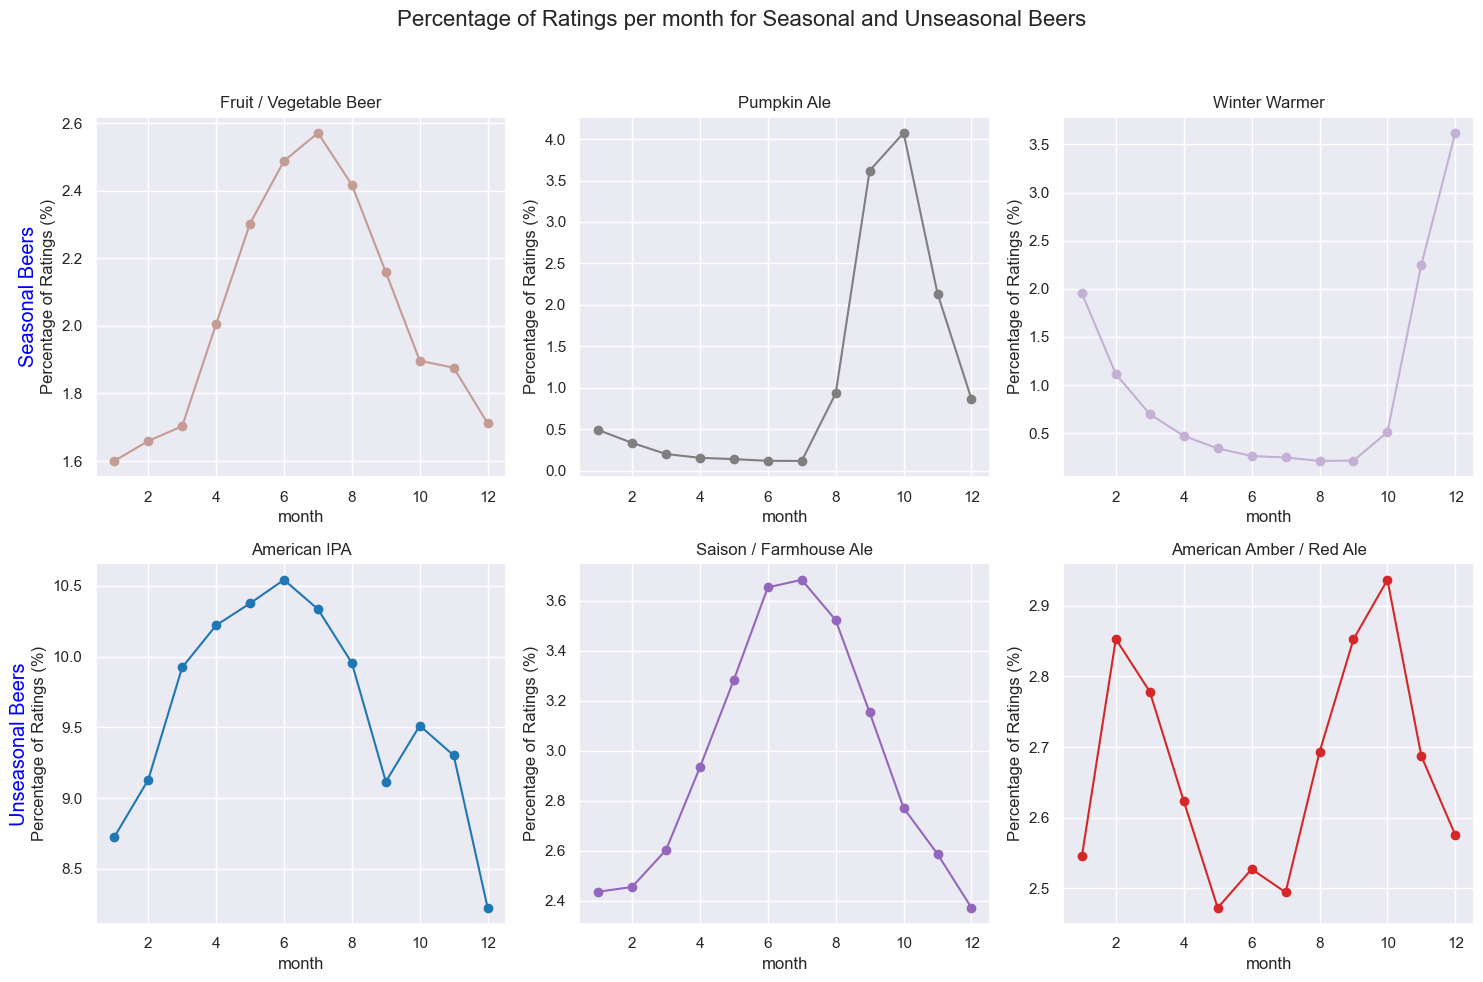

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Percentage of Ratings per month for Seasonal and Unseasonal Beers', fontsize=16)

# Loop over each beer style and corresponding subplot for percentage of ratings
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    style_df = reviews_df[reviews_df['style'] == style] 
    
    monthly_counts = style_df.groupby('month').size() # Count number of ratings per month
    
    # Calculate percentage of total ratings per month
    total_monthly_ratings = reviews_df.groupby('month').size()
    monthly_percentages = (monthly_counts / total_monthly_ratings) * 100
    
    # Plot the monthly percentages on the current subplot
    ax.plot(monthly_percentages.index, monthly_percentages.values, marker='o', linestyle='-', color=style_colors[style])
    ax.set_title(style)
    ax.set_xlabel('month')
    ax.set_ylabel('Percentage of Ratings (%)')
    
    # Add the category label on the left of each row
    if idx % 3 == 0:  # Only add the label on the first column of each row
        row_label = categories[idx // 3]
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90, color='blue')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

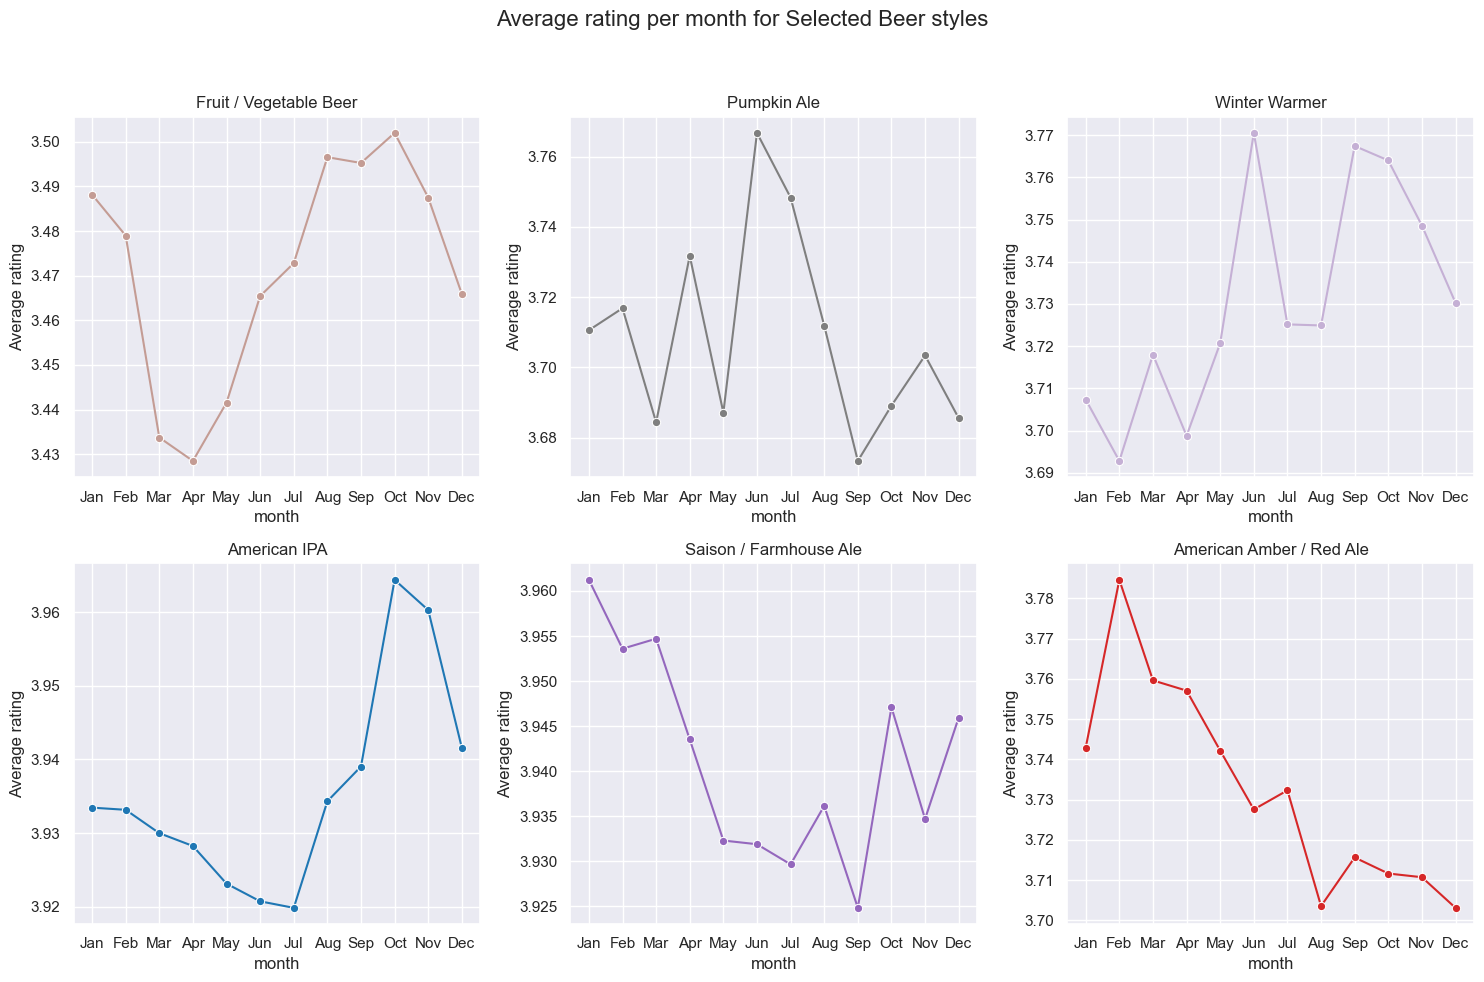

In [ ]:
# Filter the dataset for the selected beer styles
df_filtered = reviews_df[reviews_df['style'].isin(beer_styles)]

# Group by month and style, then calculate the average rating per group
monthly_ratings = df_filtered.groupby(['month', 'style'])['rating'].mean().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loop over each beer style and corresponding subplot
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    # Get data only for current subplot and plot monthly average rating
    style_df = monthly_ratings[monthly_ratings['style'] == style]
    sns.lineplot(data=style_df, x='month', y='rating', marker='o', ax=ax, color=style_colors[style])
    
    # Subplot titles
    ax.set_title(style, fontsize=12)
    ax.set_xlabel('month')
    ax.set_ylabel('Average rating')
    ax.set_xticks(range(1, 13))  # Set x-axis ticks for months
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

fig.suptitle('Average rating per month for Selected Beer styles', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


## 4.3. <a id='toc4_4_'></a>[Identifying the most seasonal beers based on our metric](#toc0_)

In this Subsection, we want to identify the most seasonal beers based on our Seasonaly Metrics defined in Section 3.
- **Avg Rating**: There are beers that get a different rating in some seasonal periods compared to others
- **# Ratings**: There are beers that get more ratings in some seasonal periods than in others

Therefore, we split the analysis in two parts and first find the most seasonal beers in terms of the Avg Rating and then we find the most seasonal beers in terms of the number of ratings. We hope that, if we combine them, we extract the most seasonal beers.

In [36]:
reviews_df = pd.read_csv("src/data/beerAdvocateReviewsUSA.csv", index_col=0)
reviews_df["date_object"] = reviews_df["date_object"].map(datetime.fromisoformat)

First we want to get rid of beers which only contain very few reviews over our investigation period. We set the threshold to 500 reviews over the period of 16 years * 12 months = 192 months.

In [37]:
# convert date to datetime

# we 16 years * 12 months = 192 months -> if a beer rating is uniformly distributed over the 196 months m. 
# With chernoff, the probability that for every beer and every month there is at least 1 review of that beer is >= 1 - m*e^{-n/m} (m is the nr of months, n the numbers of reviews for the beer)
# >= 1 - 192*exp(-1500/192) > 0.95 for n=1500 samples per beer.

CUTOFF = 500 # cutoff for beers to get into the stats

print("Nr of reviews before getting rid of beers with only a few reviews: ", reviews_df.shape[0])
print("Nr of beers before getting rid of beers with only a few reviews:", len(reviews_df["beer_name"].unique()))

# trash all with less rating than CUTOFF
grouped_df = reviews_df.groupby("beer_id").agg(count = ("rating", "count")).reset_index()
grouped_df = grouped_df[grouped_df["count"] >= CUTOFF]
ids = grouped_df["beer_id"] # id's for beers with more than cutoff beers


reduced_df = reviews_df[reviews_df["beer_id"].isin(ids)]
print("Nr of reviews after getting rid of beers with only a few reviews: ", reduced_df.shape[0])
print("Nr of beers after getting rid of beers with only a few reviews:", len(reduced_df["beer_name"].unique()))



Nr of reviews before getting rid of beers with only a few reviews:  2239823
Nr of beers before getting rid of beers with only a few reviews: 119591
Nr of reviews after getting rid of beers with only a few reviews:  711007
Nr of beers after getting rid of beers with only a few reviews: 736


### Avg Rating

Then we compute the seasonality metrics for each beer on the beers average rating of every month from 2002 to 2017. As, with the threshold set to 500 reviews over the period, the probability is high that the beer doesn't contain a review for every month, we linearly interpolate the missing values.

In [38]:
# initialize new dataframe to store the seasonality metrics
seasonality_avg_df = reduced_df.groupby("beer_name")["rating"].agg("mean").reset_index()
seasonality_avg_df = seasonality_avg_df.set_index("beer_name")

for beerName in reduced_df["beer_name"].unique():

    timeseries_data  = sm.data_preprocessing_mean_rating_per_month(reduced_df[reduced_df["beer_name"] == beerName], 'mean_rating')

    # linear interpolation of missing monthly values
    timeseries_data, nrInterpolated = sm.interpolate_missing_vals_monthly_avg(timeseries_data, col_to_interpolate="mean_rating")
   
    peak_ratio, avg_amplitude = sm.timeseries_seasonality_metric(timeseries_data)

    seasonality_avg_df.loc[beerName, "peak_ratio"] = peak_ratio
    seasonality_avg_df.loc[beerName, "avg_amplitude"] = avg_amplitude
    seasonality_avg_df.loc[beerName, "nr_interpolated"] = nrInterpolated

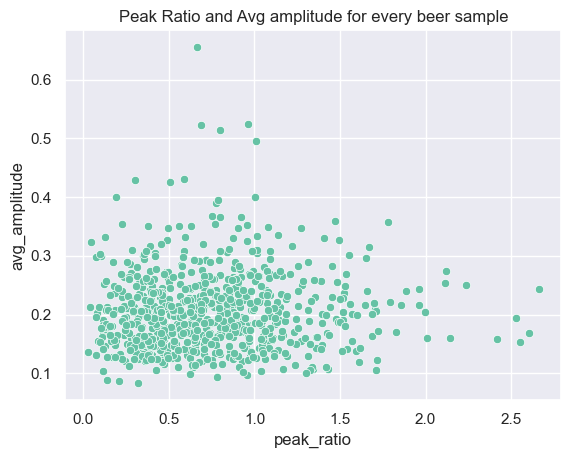

In [39]:
s = sns.scatterplot(seasonality_avg_df, x="peak_ratio", y="avg_amplitude")
s.set_title("Peak Ratio and Avg amplitude for every beer sample")
plt.show()

A beer with a high average amplitude but with a small peak ratio could just be a beer with high variance in the rating and the other way around the seasonal impact isn't very high. What we're looking are beers with high values on both metrics. If we multyply the two metrics, the average amplitude gets too much weight and beers with high variance overtake. We figured that the best way is to normalize the amplitude and add them. Therefore we filter the beers with the sum of the two metrics: 
$$combined\_seasonlity = normalized(avg\_amplitude) + peak\_ratio$$

In [40]:
# we rate the beers based on
def normalize(x):
    return x / np.sqrt(np.sum(x**2))

seasonality_avg_df["combined_seasonality_avg"] = seasonality_avg_df["peak_ratio"].to_numpy() + normalize(seasonality_avg_df["avg_amplitude"].to_numpy())
seasonality_avg_df = seasonality_avg_df.sort_values("combined_seasonality_avg", ascending=False)

In [41]:
df = seasonality_avg_df.head(10)
fig = px.bar(df, y=df.index, x="combined_seasonality_avg", color=df.index, title="Beers with highest seasonality in their ratings", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("src/plotly-html-graphs/tim/avg_rating/highestsSeasonalityRating.html")
fig.show()

In [42]:
df = seasonality_avg_df.tail(10)
fig = px.bar(df, y=df.index, x="combined_seasonality_avg", color=df.index, title="Beers with lowest seasonality in their ratings", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("src/plotly-html-graphs/tim/avg_rating/lowestSeasonalityRating.html")

fig.show()

Now we want to show the same plot as in section 2.2 with the average rating over the beers per month but without the first t*100% most seasonal beers. We do that for different thresholds t.

In [43]:
# add boolean for different thresholds
thresholds = [0.005, 0.01, 0.05, 0.1]
nr_thresholds = len(thresholds)

# copy the dataframe for each threshold
repeated_df = seasonality_avg_df.loc[np.repeat(seasonality_avg_df.index, nr_thresholds)]
repeated_df['thresh'] = np.tile(thresholds, len(seasonality_avg_df))

# repeat dataframe for every threshold
for threshold in thresholds:
    nrTrues = int(len(seasonality_avg_df) * threshold)
    nrFalse = len(seasonality_avg_df) - nrTrues
    boolArr = np.concat((np.repeat(True, nrTrues), np.repeat(False, nrFalse)))
    repeated_df.loc[repeated_df["thresh"] == threshold, "is_seasonal"] = boolArr


# merge with the entire dataframe to get the ratings per month
repeated_df = repeated_df.drop(columns="rating") #drop rating as this is the mean rating which we don't need anymore
reviews_peak_thresh_df = pd.merge(repeated_df, reviews_df, how="left", on="beer_name")

#group by month for the plot
grouped_seasonality_thresh_df = reviews_peak_thresh_df.groupby(["thresh", "is_seasonal", "month"])["rating"].agg("mean").reset_index()

# grouped_seasonality_thresh_df.head()

In [96]:
fig = px.line(grouped_seasonality_thresh_df, x="month", y="rating", color="is_seasonal", facet_col="thresh", facet_col_wrap=1,
       facet_row_spacing=0.1,
       title="Avg rating per month for different thresholds on combined seasonality metric"
       )
fig.for_each_annotation(lambda a: a.update(text=f'Threshold (ratio of beers classified as seasonal): {a.text.split("=")[-1]}'))
fig.write_html("src/plotly-html-graphs/tim/avg_rating/differentSeasonalityThresholds.html")
fig.show()

In [44]:
# show the variance for the residual 
df = grouped_seasonality_thresh_df[grouped_seasonality_thresh_df["is_seasonal"]]
df.loc[:, "thresh_str"] = df.loc[:, "thresh"].map(str)
fig = px.box(df, x="thresh_str", y="rating", color="thresh_str", labels={"thresh_str": "Threshold (Ratio of beers classified as seasonal)", "rating": "Rating"},
             title="Mean monthly average and variance of seasonal beers for different thresholds")
fig.update_layout(showlegend=False)

fig.write_html("src/plotly-html-graphs/tim/avg_rating/boxGroupedMonthlyMeanSeasonal.html")
fig.show()

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_69165/2066966911.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We can see that, the more seasonal beers we exclude, the variance of the residual decreases which. We get the highest reduction if we exclude the 5% most seasonal beers (of the reduced dataset).

In [75]:
grouped_seasonality_thresh_df.head()

thresh  is_seasonal  month    rating
0   0.005        False      1  3.988339
1   0.005        False      2  3.988834
2   0.005        False      3  3.981715
3   0.005        False      4  3.974009
4   0.005        False      5  3.960251

With the following graph we want to show that the combined_seasonality isn't just a measure of variance:

In [79]:
grouped_beer_stats_df = reviews_df.groupby(["beer_name", "month"])["rating"].agg(["mean"]).reset_index() # compute vals over months
grouped_beer_stats_df = grouped_beer_stats_df.groupby("beer_name").agg(var_over_months = ("mean", np.nanvar)).reset_index() # compute variance over mean of months for each beer
grouped_beer_stats_df = pd.merge(seasonality_avg_df, grouped_beer_stats_df, on="beer_name")
fig = px.scatter(grouped_beer_stats_df, x="combined_seasonality_avg", y="var_over_months", labels={"combined_seasonality_avg": "Combined Seasonality Metric",
                  "var_over_months": "Variance over month mean"},
                  title="Variance over monthly mean rating and Peak Ratio Metric for each Beer"
                  )
fig.update_yaxes(range=[-0.01, 0.05])
fig.write_html("src/plotly-html-graphs/tim/avg_rating/seasonalityMetric_vs_monthlyVariance.html")
fig.show()

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_26530/3729344567.py:2: FutureWarning:

The provided callable <function nanvar at 0x1077cf6a0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.



### Nr of Ratings
Now we can do the same Analysis on the nr of ratings. Instead of interpolating missing values (as we did for the average rating) for months without ratings for this beer, we set the number of ratings to zero for that month.

The methods to compute the metrics are the same for the Nr of Ratings as for the Avg Rating (based on analysis in the Fourier domain and STL), therefore, in this subsection we still have the peak_ratio, avg_amplitude and combined_seasonality metric but now they're computed on the nr of ratings!

In [45]:

seasonality_nr_df = reduced_df.groupby("beer_name").agg(nr_ratings = ("rating", "count")).reset_index()
seasonality_nr_df = seasonality_nr_df.set_index("beer_name")


for beerName in reduced_df["beer_name"].unique():

    # data_preprocessing_number_of_ratings_per_month returns a timeseries data column and a N_ratings column
    timeseries_data  = sm.data_preprocessing_number_of_ratings_per_month(reduced_df[reduced_df["beer_name"] == beerName])
    timeseries_data = sm.zero_missing_vals_monthly_nr(timeseries_data, col_to_interpolate="N_ratings")
    
    peak_ratio, avg_amplitude = sm.timeseries_seasonality_metric(timeseries_data)
    # print(f'Beer Name: {beerName} \npeak Ratio: {peak_ratio}\navg Amplitude: {avg_amplitude}')
    # print()

    seasonality_nr_df.loc[beerName, "peak_ratio"] = peak_ratio
    seasonality_nr_df.loc[beerName, "avg_amplitude"] = avg_amplitude

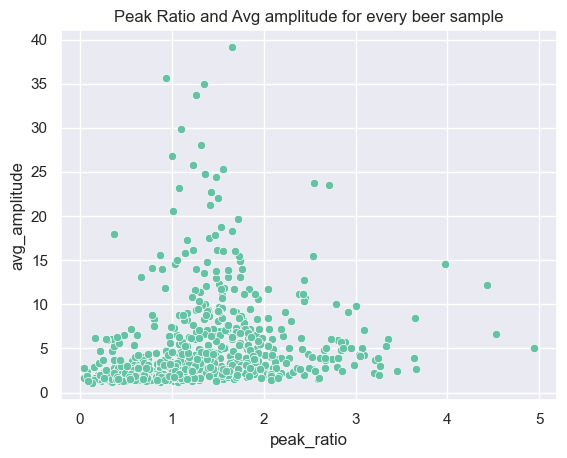

In [46]:
s = sns.scatterplot(seasonality_nr_df, x="peak_ratio", y="avg_amplitude")
s.set_title("Peak Ratio and Avg amplitude for every beer sample")
plt.show()


For the number of ratings we compute the same combined seasonality metric:
$$combined\_seasonlity = normalized(avg\_amplitude) + peak\_ratio$$

In [47]:
# we rate the beers based on the

seasonality_nr_df["combined_seasonality_nr"] = seasonality_nr_df["peak_ratio"].to_numpy() + normalize(seasonality_nr_df["avg_amplitude"].to_numpy())
seasonality_nr_df = seasonality_nr_df.sort_values("combined_seasonality_nr", ascending=False)

In [48]:
df = seasonality_nr_df.head(10)
fig = px.bar(df, y=df.index, x="combined_seasonality_nr", color=df.index, title="Beers with highest seasonality in their nr of reviews", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("src/plotly-html-graphs/tim/nr_ratings/highestsSeasonalityRating.html")
fig.show()

In [49]:
df = seasonality_nr_df.tail(10)
fig = px.bar(df, y=df.index, x="combined_seasonality_nr", color=df.index, title="Beers with lowest seasonality in their nr of reviews", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("src/plotly-html-graphs/tim/nr_ratings/lowestSeasonalityRating.html")
fig.show()

In the following two cells, we show the nr of ratings per month for the highest t*100% seasonal beers an the residual for different thresholds t. 

In [50]:
# add boolean for different thresholds
thresholds = [0.025, 0.05, 0.1, 0.3]
nr_thresholds = len(thresholds)

# copy the dataframe for each threshold
repeated_df = seasonality_nr_df.loc[np.repeat(seasonality_nr_df.index, nr_thresholds)]
repeated_df['thresh'] = np.tile(thresholds, len(seasonality_nr_df))

# repeat dataframe for every threshold
for threshold in thresholds:
    nrTrues = int(len(seasonality_nr_df) * threshold)
    nrFalse = len(seasonality_nr_df) - nrTrues
    boolArr = np.concat((np.repeat(True, nrTrues), np.repeat(False, nrFalse)))
    repeated_df.loc[repeated_df["thresh"] == threshold, "is_seasonal"] = boolArr


# merge with the entire dataframe to get the ratings per month
reviews_peak_thresh_df = pd.merge(repeated_df, reduced_df, how="left", on="beer_name")

#group by month for the plot
grouped_seasonality_thresh_df = reviews_peak_thresh_df.groupby(["thresh", "is_seasonal", "month", "beer_name"]).agg(N_ratings = ("rating", "count")).reset_index()

# mean (over beer types) number of ratings per month
grouped_seasonality_thresh_df = grouped_seasonality_thresh_df.groupby(["thresh", "is_seasonal", "month"]).agg(mean_N_ratings = ("N_ratings", "mean")).reset_index()


grouped_seasonality_thresh_df.head()

thresh  is_seasonal  month  mean_N_ratings
0   0.025        False      1       94.047354
1   0.025        False      2       84.456825
2   0.025        False      3       86.564067
3   0.025        False      4       80.370474
4   0.025        False      5       77.310585

In [51]:
fig = px.line(grouped_seasonality_thresh_df, x="month", y="mean_N_ratings", color="is_seasonal", facet_col="thresh", facet_col_wrap=1,
       facet_row_spacing=0.1,
       title="Avg number of ratings a seasonal vs non seasonal beer gets",
       labels={"mean_N_ratings": "nrRatings"}
       )
fig.for_each_annotation(lambda a: a.update(text=f'Threshold (ratio of beers classified as seasonal): {a.text.split("=")[-1]}'))
fig.write_html("src/plotly-html-graphs/tim/nr_ratings/differentPeakRatioThresholds.html")
fig.show()

In [52]:
# show the variance for the residual 
df = grouped_seasonality_thresh_df[grouped_seasonality_thresh_df["is_seasonal"]]
df.loc[:, "thresh_str"] = df.loc[:, "thresh"].map(str)
fig = px.box(df, x="thresh_str", y="mean_N_ratings", color="thresh_str", labels={"thresh_str": "Threshold (Ratio of beers classified as seasonal)", "mean_N_ratings": "Number of Ratings"},
             title="Mean monthly Nr of ratings of seasonal beers for different thresholds")
fig.update_layout(showlegend=False)

fig.write_html("src/plotly-html-graphs/tim/nr_ratings/boxGroupedMonthlyNrSeasonal.html")
fig.show()

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_69165/4204188244.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Therefore, the 2.5% most seasonal beers have, in average, 109 ratings per month and beer and a higher variance in their monthly nr of ratings than the 10% most seasonal beers.

### Combining the most seasonal beers in terms of the nr of ratings and the avg rating per month

We combine the two metrics and compute the set of most seasonal beers. We do that with the followoing metric for each beer: 
$$general\_seasonality = combined\_seasonality_avg + combined\_seasonality_nr$$

In [92]:
combined_df = pd.merge(seasonality_avg_df, seasonality_nr_df, on="beer_name")
combined_df["general_seasonality"] = combined_df["combined_seasonality_avg"] + combined_df["combined_seasonality_nr"]

combined_df = combined_df.sort_values("general_seasonality", ascending=False)

again we compute the graphs for different threshold, now on the general metric:

In [104]:
# add boolean for different thresholds
thresholds = [0.01, 0.05, 0.1, 0.3, 0.5]
nr_thresholds = len(thresholds)

# copy the dataframe for each threshold
repeated_df = combined_df.loc[np.repeat(combined_df.index, nr_thresholds)]
repeated_df['thresh'] = np.tile(thresholds, len(combined_df))

# repeat dataframe for every threshold
for threshold in thresholds:
    nrTrues = int(len(combined_df) * threshold)
    nrFalse = len(combined_df) - nrTrues
    boolArr = np.concat((np.repeat(True, nrTrues), np.repeat(False, nrFalse)))
    repeated_df.loc[repeated_df["thresh"] == threshold, "is_seasonal"] = boolArr


# merge with the entire dataframe to get the ratings per month
repeated_df = repeated_df.drop(columns="rating") #drop rating as this is the mean rating which we don't need anymore
reviews_peak_thresh_df = pd.merge(repeated_df, reviews_df, how="left", on="beer_name")

#group by month for the plot
grouped_seasonality_thresh_df = reviews_peak_thresh_df.groupby(["thresh", "is_seasonal", "month"])["rating"].agg("mean").reset_index()

# grouped_seasonality_thresh_df.head()

In [105]:
fig = px.line(grouped_seasonality_thresh_df, x="month", y="rating", color="is_seasonal", facet_col="thresh", facet_col_wrap=1,
       facet_row_spacing=0.1,
       title="Avg rating per month for most seasonal beers and the residual"
       )
fig.for_each_annotation(lambda a: a.update(text=f'Threshold (ratio of beers classified as seasonal): {a.text.split("=")[-1]}'))
fig.write_html("src/plotly-html-graphs/tim/differentSeasonalityThresholds.html")
fig.show()

And here we have the podium!

In [111]:
df = combined_df.head(5)
fig = px.bar(df, y=df.index, x="general_seasonality", color=df.index, title="Our most seasonal beers", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("src/plotly-html-graphs/tim/highestsSeasonalityBeers.html")
fig.show()

We can also set custom thresholds on the two sets. The follwing are the graphs if we take the 10% most seasonal nr ratings and 5% avg rating and combine them:

In [133]:
beers_avg = seasonality_avg_df.head(int(0.05 * len(seasonality_avg_df))).index
beers_nr = seasonality_nr_df.head(int(0.1 * len(seasonality_nr_df))).index
seasonal_beers = np.concatenate((beers_avg, beers_nr))

print(f"Nr of seasonal beers: {len(seasonal_beers)}")

print("Seasonal part:")
line1, ci1 = sm.monthly_avg_ci_traces(reduced_df.loc[reduced_df["beer_name"].isin(seasonal_beers)], title="Seasonal part")

print("Non Seasonal part:")
line2, ci2 = sm.monthly_avg_ci_traces(reduced_df.loc[~reduced_df["beer_name"].isin(seasonal_beers)], title="Non Seasonal part")

fig = go.Figure(data=[line2, ci2, line1, ci1])

# Add layout for better appearance
fig.update_layout(
    title='Non seasonal beers vs seasonal beers',
    xaxis_title='Month',
    yaxis_title='Avg Monthly Rating',
    # legend=dict(title='Legend')
)
fig.write_html("src/plotly-html-graphs/tim/seasonalVsNonSeasonalCustomThresholds.html")
fig.show()

Nr of seasonal beers: 109
Seasonal part:
Variance over the means: 0.001832143169516502
Non Seasonal part:
Variance over the means: 0.00020192235742068625


### Degree of seasonality depending on latitude

We initially considered exploring the degree of seasonality depending on latitude to understand how variations in weather conditions, influenced by geographical location, might affect beer ratings. The basic idea was that regions further from the equator experience more pronounced seasonal changes, which could potentially impact local beer preferences and ratings. However, after reviewing the literature, we found that defining a "degree of seasonality" solely based on latitude is overly simplistic and not widely established in existing studies.  

In a relevant study (https://academic.oup.com/icb/article/57/5/934/3896236), it was highlighted that seasonality is influenced by factors beyond latitude, such as the Earth's axial tilt, which causes different regions at the same latitude to experience varying degrees of seasonality. Factors like day length and temperature, which are not directly linked to latitude, also play a crucial role in determining seasonal changes. While weather data could provide insights into these variables, we would still face challenges in combining them into a comprehensive metric for seasonality.  

Given these complexities and the lack of a well-defined measure in the literature, we decided to abandon the idea of creating a latitude-based seasonality metric, as it would have required arbitrary assumptions and lacked a clear, scientifically grounded foundation.  

# 5. <a id='toc5_'></a>[Weather Influence](#toc0_)

## 5.1. <a id='toc5_1_'></a>[climatezone per country / state](#toc0_)

### US States

- decide on a states climatezone based on the counties climatezones and weighted by population. In other words: in what climate zones do people in that state live We do this to anaylze in what conditions beer-reviewers live.
County climatezone data from US department for energy: https://www.energy.gov/sites/prod/files/2015/10/f27/ba_climate_region_guide_7.3.pdf
- county population data from: https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html
- used formatted table from github: https://gist.github.com/philngo/d3e251040569dba67942#file-climate_zones-csv
- state abbreviation list:https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html


In [144]:
# Define paths
countiesClimate_df_path = "data/climatezones/climate_zones.csv"
countiesPopulation_df_path = "data/climatezones/countyPopulation.xlsx"

# Get the climate data with population
climate_data_with_population = WaH.add_population_to_climate_data(countiesClimate_df_path, countiesPopulation_df_path)

# Get the most populated climate zone for each state
most_populated_climate_zone = WaH.get_most_populated_climate_zone(climate_data_with_population)

#replace 'State' with 'abbreviation'
most_populated_climate_zone = most_populated_climate_zone.rename(columns={'State': 'abbreviation'})

# View the result
most_populated_climate_zone.head()

/home/nfilimonov/Documents/GitHub/ada-2024-project-leonardodatavinci/src/utils/USClimateAndWeatherHelper.py:25: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



abbreviation  IECC Climate Zone  Population
0           AK                  7    555076.0
3           AL                  3   4377717.0
4           AR                  3   3483542.0
6           AS                  1         0.0
7           AZ                  2   6116085.0

## 5.2. <a id='toc5_2_'></a>[Extracting weather data from excel files](#toc0_)

### Loading the Dataset
Loading the beer reviews dataset from CSV file containing reviews and ratings from USA. This dataset has been preprocessed according to the section `Preprocessing`


In [145]:
df = pd.read_csv("src/data/beerAdvocateReviewsUSA.csv") # dataset containing reviews and ratings

### Extracting Weather Data from Excel Files

In this section, we extract weather data, specifically precipitation and temperature, from historical datasets provided by the [World Bank Climate Data](https://climateknowledgeportal.worldbank.org/download-data). These datasets include monthly average temperature and precipitation values spanning a period from 1901 to 2022. 

Using a custom helper function, `WaH.extract_data_from_excel`, we process the raw Excel files to extract relevant data columns such as `state`, `value`, `year`, and `month`. The processed data is then exported as CSV files for further analysis and integration with other datasets. 

The precipitation data is saved to `data/weather-data/us-precipitations.csv`, while the temperature data is saved to `data/weather-data/us-temperatures.csv`. This structured format allows for easy integration into subsequent analyses, such as correlating weather patterns with beer ratings across different states in the United States. 

The exported datasets serve as the foundation for visualizations and analyses that aim to understand the potential impact of weather on consumer behavior.

In [146]:
precipitation_df = WaH.extract_data_from_excel('data/weather-data/cru-x0.5_timeseries_pr_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')
temperature_df = WaH.extract_data_from_excel('data/weather-data/cru-x0.5_timeseries_tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')

#export to csv
precipitation_df.to_csv('data/weather-data/us-precipitations.csv', index=False)
temperature_df.to_csv('data/weather-data/us-temperatures.csv', index=False)

precipitation_df

code                     state   value  year  month
0              USA  United States of America   46.10  1901      1
1      USA.2593214                   Alabama  116.85  1901      1
2      USA.2593215                    Alaska   35.22  1901      1
3      USA.2593216                   Arizona   24.17  1901      1
4      USA.2593217                  Arkansas   60.62  1901      1
...            ...                       ...     ...   ...    ...
76123  USA.2593260                  Virginia   96.01  2022     12
76124  USA.2593261                Washington  169.15  2022     12
76125  USA.2593262             West Virginia   82.01  2022     12
76126  USA.2593263                 Wisconsin   50.55  2022     12
76127  USA.2593264                   Wyoming   30.11  2022     12

[76128 rows x 5 columns]

#### Determining the timeframe of the weather data


In [147]:
# Compute oldest and newest year
oldest_year = min(precipitation_df['year'].min(), temperature_df['year'].min())
newest_year = max(precipitation_df['year'].max(), temperature_df['year'].max())

# Print the oldest and newest year
print(f"Oldest year: {oldest_year}")
print(f"Newest year: {newest_year}")


Oldest year: 1901
Newest year: 2022


### Filtering and Enhancing Beer Data with Weather Information

In this section, we prepare the beer ratings dataset by focusing on data relevant to the United States and filtering it for the years 2002 to 2017. These steps are essential to ensure consistency with the timeframe of the weather data and to analyze beer ratings at a granular, state-specific level.

#### Filtering for US Data
The dataset is first filtered to include only records where the `country_name` is "United States." This step ensures that all analyses are focused exclusively on US-specific data.

#### Restricting the Timeframe
The data is further narrowed down to reviews between 2002 and 2017, a period with sufficient overlap between beer reviews and weather records. This step is critical for analyzing seasonal trends and potential correlations between beer ratings and weather conditions.

#### Adding Weather Data
To enrich the beer data:
- **Precipitation** and **Temperature** data for each state are added by applying the `WaH.apply_value_from_date_and_state` function. This function aligns each beer review with the corresponding state's monthly average precipitation and temperature.
- The dataset is merged with the `most_populated_climate_zone` data to include climate zone information, providing additional context for regional analyses.

#### Final Dataset
The resulting dataset contains beer review information augmented with precipitation, temperature, and climate zone details. This enriched dataset forms the foundation for exploring correlations between weather patterns and beer ratings, enabling state-level and temporal analyses.

The population count is also added, although irrelevant for the upcoming steps.

In [148]:
month = 1
year = 1986
state = "United States of America"

precipitation_USA_1986_1 = WaH.value_from_date_and_state(precipitation_df, year, month, state)
print(f"Precipitation in {state} in {month}-{year}: {precipitation_USA_1986_1}")

Precipitation in United States of America in 1-1986: 36.83


In [149]:
beer_data = df

In [150]:
# Filter for US only
beer_data_with_weather = beer_data[beer_data["country_name"] == "United States"]

#Filter for years between 2002 and 2017
beer_data_with_weather = beer_data_with_weather[(beer_data_with_weather["year"] >= 2002) & (beer_data_with_weather["year"] <= 2017)]

# print shape
print("original shape: ", beer_data.shape)
print("new shape: ", beer_data_with_weather.shape)


beer_data_with_weather = WaH.apply_value_from_date_and_state(beer_data_with_weather,precipitation_df, "Precipitation")
beer_data_with_weather = WaH.apply_value_from_date_and_state(beer_data_with_weather,temperature_df, "Temperature")
beer_data_with_weather = preProcessingHelper.merge_with_states(beer_data_with_weather)

# merge most_populated_climate_zone with df
beer_data_with_weather = beer_data_with_weather.merge(most_populated_climate_zone, how='left', on='abbreviation')

beer_data_with_weather.head()

original shape:  (2240430, 13)
new shape:  (2239823, 13)


rating  appearance  aroma  palate  taste  overall   country_name  \
0    2.88        3.25   2.75    3.25   2.75     3.00  United States   
1    3.67        3.00   3.50    3.50   4.00     3.50  United States   
2    3.91        4.25   4.50    3.25   3.75     3.75  United States   
3    3.64        4.00   3.75    3.50   3.50     3.75  United States   
4    2.77        3.00   3.50    2.50   2.50     2.50  United States   

  country_code3           state          date_object  month  year  \
0           USA      Washington  2015-08-20 12:00:00      8  2015   
1           USA        New York  2009-02-20 12:00:00      2  2009   
2           USA  North Carolina  2013-02-13 12:00:00      2  2013   
3           USA        New York  2013-01-09 12:00:00      1  2013   
4           USA        Illinois  2012-11-17 12:00:00     11  2012   

              style  Precipitation  Temperature abbreviation  \
0   Euro Pale Lager          40.63        19.08           WA   
1  English Pale Ale          43.11        -4.40           NY   
2  English Pale Ale         108.89         5.84           NC   
3  English Pale Ale          56.13        -4.27           NY   
4  English Pale Ale          29.50         5.59           IL   

   IECC Climate Zone  Population  
0                  4   2658093.0  
1                  5   7878123.0  
2                  4   8582452.0  
3                  5   7878123.0  
4                  5   6671604.0

## 5.3. <a id='toc5_3_'></a>[Data Analysis](#toc0_)

### Timeline and number of reviews

#### 1. Number of Rows per Month/Year
- A `date` column was created by combining year and month for grouping data by specific months.
- The number of reviews per month was counted and plotted using Plotly Express, with time on the x-axis (`Year-Month`) and review counts on the y-axis.
- The x-axis was formatted for better readability.

**Output**: `number_of_rows_per_month_year.html` (interactive line plot).

#### 2. Timeline of the Dataset
- The dataset's temporal span was visualized using a timeline with start and end dates (`start_date` and `end_date`).
- A line with markers shows the dataset's coverage, formatted for clarity.

**Output**: `timeline.html` (interactive timeline).

In [151]:
# Create a 'date' column for easier grouping
beer_data_with_weather['date'] = pd.to_datetime(beer_data_with_weather[['year', 'month']].assign(day=1))

# 1. Plot month/year vs. number of rows using Plotly

# Count the number of rows per unique date
row_counts = beer_data_with_weather['date'].value_counts().sort_index()

# Create a line plot using Plotly Express
fig = px.line(
    x=row_counts.index,
    y=row_counts.values,
    labels={'x': 'Date', 'y': 'Number of Rows'},
    title='Number of Rows per Month/Year'
)

# Update layout for better appearance
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',
        tickangle=45
    ),
    xaxis_tickformatstops=[
        dict(dtickrange=[None, None], value="%Y-%m")
    ]
)

#Save the plot
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/number_of_rows_per_month_year.html")

# 2. Plot a timeline with start month/year and end month/year using Plotly

# Get the start and end dates
start_date = beer_data_with_weather['date'].min()
end_date = beer_data_with_weather['date'].max()

# Create a figure
fig_timeline = go.Figure()

# Add a line and markers to represent the timeline
fig_timeline.add_trace(go.Scatter(
    x=[start_date, end_date],
    y=[0, 0],
    mode='lines+markers',
    marker=dict(size=10),
    line=dict(width=2),
    showlegend=False
))

# Update layout for the timeline
fig_timeline.update_layout(
    title=f'Timeline of Dataset<br><sup>Start: {start_date.strftime("%Y-%m")} | End: {end_date.strftime("%Y-%m")}</sup>',
    xaxis_title='Date',
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    xaxis=dict(
        tickformat='%Y-%m',
        tickangle=45
    ),
    height=200,
    margin=dict(l=50, r=50, t=80, b=50)
)


#Save the plot
fig_timeline.show()
fig_timeline.write_html("src/plotly-html-graphs/nicolas/timeline.html")

## 5.4. <a id='toc5_4_'></a>[Descriptive Statistics for Weather Data](#toc0_)

This analysis provides a summary of statistical metrics for temperature, precipitation, and IECC climate zones across the dataset:

- **Data Scope**: Metrics such as count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile), 75th percentile (Q3), and maximum values were computed.
- **Temperature**: Ranges from -26.49°C to 31.23°C, with an average of 11.52°C and a standard deviation of 9.67°C.
- **Precipitation**: Ranges from 0.26 mm to 466.47 mm, with an average of 85.23 mm and a standard deviation of 48.06 mm.
- **IECC Climate Zone**: Categorized into discrete values from 1 to 7, with a mean of 4.32 and a standard deviation of 1.09.

In [152]:
# Descriptive statistics for weather data
weather_stats = beer_data_with_weather[['Temperature', 'Precipitation', 'IECC Climate Zone']].describe()
print("Descriptive Statistics for Weather Data:")
print(weather_stats)


Descriptive Statistics for Weather Data:
        Temperature  Precipitation  IECC Climate Zone
count  2.239823e+06   2.239823e+06       2.239823e+06
mean   1.151837e+01   8.522982e+01       4.318092e+00
std    9.671731e+00   4.805576e+01       1.092408e+00
min   -2.649000e+01   2.600000e-01       1.000000e+00
25%    4.140000e+00   5.105000e+01       4.000000e+00
50%    1.202000e+01   8.198000e+01       5.000000e+00
75%    1.973000e+01   1.143600e+02       5.000000e+00
max    3.123000e+01   4.664700e+02       7.000000e+00


### Visualizing Average Temperature Across States

In this section, we explore different ways to visualize average temperature data across states and months. The goal was to find the most effective visualization method for our dataset. Ultimately, the animated map proved to be the most informative and visually appealing option, so we decided to focus on that format for further analysis.

---

#### Average Monthly Temperature by State

- **Description**: This cell calculates the average monthly temperature for each state and creates a line plot to visualize temperature trends over the months.
- **Purpose**: To observe temperature variations across states over the course of a year.
- **Code Highlights**:
  - Uses `groupby` to calculate the average temperature by state and month.
  - Creates a line plot with states represented by different colors.
  - Updates the x-axis to display months as names (e.g., Jan, Feb, etc.).
- **Outcome**: A multi-line plot showcasing monthly temperature trends for each state.

In [153]:
# Average temperature per month for each state
avg_temp_state = beer_data_with_weather.groupby(['state', 'month'])['Temperature'].mean().reset_index()

# Plot
fig = px.line(avg_temp_state, x='month', y='Temperature', color='state', 
              title="Average Monthly Temperature by State",
              labels={'Temperature': 'Avg Temperature (°C)', 'month': 'Month', 'state': 'State'})
fig.update_layout(xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

#save
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/avg_temp_state.html")


#### Heatmap of Average Temperature by State and Month

- **Description**: This cell calculates the average temperature for each state and month, then visualizes the data as a heatmap.
- **Purpose**: To provide a compact view of how temperatures vary across states and months in a grid format.
- **Code Highlights**:
  - Uses `groupby` to aggregate temperature data by state and month.
  - Creates a heatmap with states on the x-axis and months on the y-axis.
  - Displays average temperatures using a color gradient for easy interpretation.
- **Outcome**: A heatmap offering a quick overview of temperature patterns across states and months.

In [154]:
# Calculate average temperature by state and month
temp_heatmap = beer_data_with_weather.groupby(['state', 'month'])['Temperature'].mean().reset_index()

# Create heatmap with inverted axes (months on y-axis, states on x-axis)
fig = px.imshow(temp_heatmap.pivot(index='month', columns='state', values='Temperature'),
                labels=dict(x="State", y="Month", color="Avg Temperature (°C)"),
                y=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                title="Average Temperature by Month and State")


# Save plot
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/heatmap.html")

#### Animated Map of Average Temperature by State

- **Description**: This cell calculates the average monthly temperature for each state (using abbreviations) and visualizes the data as an animated choropleth map.
- **Purpose**: To showcase how average temperatures vary across states over time in a dynamic and engaging way.
- **Code Highlights**:
  - Uses `groupby` to calculate state-level monthly averages.
  - Merges data with state abbreviations for consistency.
  - Creates an animated choropleth map with a color gradient indicating temperature ranges.
  - Customizes the animation speed for smooth transitions between months.
- **Outcome**: An interactive map where users can observe how temperatures evolve across the USA over the course of a year.

In [155]:
# Calculate the average temperature by state abbreviation
state_monthly_avg_temp = beer_data_with_weather.groupby(['abbreviation', 'month'])['Temperature'].mean().reset_index()

state_monthly_avg_temp = preProcessingHelper.merge_with_abbreviations(state_monthly_avg_temp)

state_monthly_avg_temp.head()

abbreviation  month  Temperature   state
0           AK      1   -17.886830  Alaska
1           AK      2   -15.535399  Alaska
2           AK      3   -12.840988  Alaska
3           AK      4    -4.540952  Alaska
4           AK      5     3.844366  Alaska

In [156]:
# Define fixed color scale range
min_temp = state_monthly_avg_temp['Temperature'].min()  # e.g., -35
max_temp = state_monthly_avg_temp['Temperature'].max()  # e.g., 30

# Create the timelapse choropleth map
fig = px.choropleth(
    state_monthly_avg_temp,
    locations='abbreviation',           # Column with state abbreviations
    locationmode='USA-states',           # Specifies that locations are USA states
    color='Temperature',                 # Data to color the states by
    hover_name='state',                  # Display full state name on hover
    scope='usa',                         # Focuses the map on the USA
    color_continuous_scale='Viridis',    # Color scale
    labels={'Temperature': 'Avg Temperature (°C)', 'month': 'Month'},
    title='Average Temperature by State in the USA Over Time',
    animation_frame='month',             # Create animation based on the month
    range_color=[min_temp, max_temp]     # Set fixed scale for the color range
)

# Customize animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500  # Adjust speed (milliseconds per frame)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 300

# Save Timelapse
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/timelapse_temperature.html")


#### **Conclusion**

We experimented with various visualization techniques, including line plots, heatmaps, and animated maps, to explore average temperature data. While each method provided unique insights, the animated map stood out as the most intuitive and visually engaging representation. Consequently, we focused on this approach for presenting our findings.

### Climate Zones

Here, we create a static map to display the IECC Climate Zones across the United States. 

This visualization provides a comprehensive view of how different climate zones are distributed throughout the country. 

Using px.choropleth, states are colored according to their respective climate zones.

In [157]:
# Map of IECC Climate Zones

fig = px.choropleth(most_populated_climate_zone, 
                    locations='abbreviation', 
                    locationmode='USA-states', 
                    color='IECC Climate Zone', 
                    hover_name='abbreviation', 
                    scope='usa', 
                    color_discrete_sequence=px.colors.sequential.Plasma_r, 
                    title='IECC Climate Zones in the USA')

fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/climate_zones.html")

### Precipitations

Next, we focus on precipitation levels, crafting a dynamic timelapse map to visualize monthly precipitation changes across states. 

To achieve this, we calculate the average monthly precipitation for each state, ensuring the data is consistent by merging it with state names and abbreviations. 

Overall the map is created like the temperature animation.

In [158]:
# Calculate the average temperature by state abbreviation
state_monthly_avg_prec = beer_data_with_weather.groupby(['abbreviation', 'month'])['Precipitation'].mean().reset_index()

state_monthly_avg_prec = preProcessingHelper.merge_with_abbreviations(state_monthly_avg_prec)

state_monthly_avg_prec.head()

abbreviation  month  Precipitation   state
0           AK      1      39.538007  Alaska
1           AK      2      35.619979  Alaska
2           AK      3      29.282634  Alaska
3           AK      4      27.972048  Alaska
4           AK      5      28.570352  Alaska

In [159]:
# Define fixed color scale range for precipitation
min_precipitation = state_monthly_avg_prec['Precipitation'].min()  # Minimum precipitation value
max_precipitation = state_monthly_avg_prec['Precipitation'].max()  # Maximum precipitation value

# Create the timelapse choropleth map for precipitation
fig = px.choropleth(
    state_monthly_avg_prec,
    locations='abbreviation',           # Column with state abbreviations
    locationmode='USA-states',          # Specifies that locations are USA states
    color='Precipitation',              # Data to color the states by
    hover_name='state',                 # Display full state name on hover
    scope='usa',                        # Focuses the map on the USA
    color_continuous_scale='Blues',     # Color scale for precipitation
    labels={'Precipitation': 'Avg Precipitation (mm)', 'month': 'Month'},
    title='Average Precipitation by State in the USA Over Time',
    animation_frame='month',            # Create animation based on the month
    range_color=[min_precipitation, max_precipitation]  # Set fixed scale for the color range
)

# Customize animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500  # Adjust speed (milliseconds per frame)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 300

# Save Timelapse
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/timelapse_precipitation.html")


### Combined Weather Metrics Visualization

To provide another view of the key weather metrics across U.S. states, we create a **Parallel Coordinates Plot**. This visualization allows us to represent multiple variables—temperature, precipitation, and climate zones—alongside state identifiers in a compact and interactive format. This method is particularly suitable for exploring potential patterns and correlations across multiple dimensions of the data.

#### Data Preparation

First, we calculate the average temperature and precipitation for each state by grouping the dataset by state abbreviations. The IECC Climate Zone data, which is static, is merged with the weather metrics to form a complete dataset. To facilitate easy mapping in the plot, state names are encoded as numerical values using a custom mapping. This step ensures that states can be represented consistently while retaining their unique identities in the plot.

#### Visualization

The **Parallel Coordinates Plot** is constructed using `plotly.graph_objects`. Each line in the plot corresponds to a state, and the axes represent the variables:

- **State (encoded numerically)**: This axis allows for distinguishing between states, with hover functionality for easy identification.
- **Average Temperature (°C)**: Displays the average temperature for each state, normalized to a consistent range.
- **Average Precipitation (mm)**: Represents the state's precipitation levels.
- **Climate Zone**: Encodes the IECC Climate Zone classification for each state.


In [160]:
# Calculate the average temperature by state
state_temp = beer_data_with_weather.groupby(['abbreviation'])['Temperature'].mean().reset_index()

#Calculate the average precipitation by state
state_climate_zone = most_populated_climate_zone[['abbreviation', 'IECC Climate Zone']]

state_precip = beer_data_with_weather.groupby(['abbreviation'])['Precipitation'].mean().reset_index()

# Merge the dataframes
state_weather = pd.merge(state_temp, state_precip, on='abbreviation')
state_weather = pd.merge(state_weather, state_climate_zone, on='abbreviation')

state_weather = preProcessingHelper.merge_with_abbreviations(state_weather)

state_weather.head()

abbreviation  Temperature  Precipitation  IECC Climate Zone       state
0           AK    -5.983656      44.160920                  7      Alaska
1           AL    17.964573     116.981815                  3     Alabama
2           AR    16.657295     109.090646                  3    Arkansas
3           AZ    15.891391      23.270039                  2     Arizona
4           CA    14.428512      42.936489                  3  California

In [161]:
# Create a mapping of state abbreviations to numerical values
state_mapping = {state: i for i, state in enumerate(state_weather['state'].unique())}
state_weather['state_num'] = state_weather['state'].map(state_mapping)

# Create the parallel coordinates plot
fig = go.Figure(data=go.Parcoords(
    line=dict(color=state_weather['Temperature'],
              showscale=True,
              cmin=state_weather['Temperature'].min(),
              cmax=state_weather['Temperature'].max()),
    dimensions=[
        dict(
            range=[min(state_mapping.values()), max(state_mapping.values())],
            label='State',
            values=state_weather['state_num'],
            tickvals=list(state_mapping.values()),
            ticktext=list(state_mapping.keys())
        ),
        dict(
            range=[state_weather['Temperature'].min(), state_weather['Temperature'].max()],
            label='Avg Temperature (°C)',
            values=state_weather['Temperature']
        ),
        dict(
            range=[state_weather['Precipitation'].min(), state_weather['Precipitation'].max()],
            label='Avg Precipitation (mm)',
            values=state_weather['Precipitation']
        ),
        dict(
            range=[state_weather['IECC Climate Zone'].min(), state_weather['IECC Climate Zone'].max()],
            label='Climate Zone',
            values=state_weather['IECC Climate Zone']
        )
    ]
))

# Update layout
fig.update_layout(
    title='Parallel Coordinates Plot of State Weather Data',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save the plot as an HTML file
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/Weather_overview.html")


### Combined Timelapse Visualization

This script provides an interactive visualization to explore three metrics—average temperature, average precipitation, and climate zones—across U.S. states over time. The visualization is implemented as a **timelapse map** that users can interact with using dropdown menus and play/pause buttons. The animation offers both spatial and temporal insights, making it an effective way to analyze patterns in weather and climate data.

#### Data Preparation

We use three datasets for this visualization:
1. **Temperature Data**: Average monthly temperature for each state.
2. **Precipitation Data**: Average monthly precipitation for each state.
3. **Climate Zone Data**: IECC Climate Zone classification for each state (static, not changing over time).

#### Animation Frames

The animation frames are generated for each month:
- Each frame includes data for temperature, precipitation, and climate zones for that specific month.
- Frames allow users to play an animated sequence that cycles through all months, showing the temporal evolution of temperature and precipitation.

#### Interactive Features

The visualization includes:
- **Dropdown Menu**: Allows users to toggle between temperature, precipitation, and climate zone maps. Only the selected metric is displayed at any given time.
- **Play/Pause Buttons**: Users can play the timelapse to view changes month-by-month or pause it to analyze specific months.
- **Slider**: Provides an interactive way to select months. Users can slide through months to see the data for specific points in time. The slider also displays abbreviated month names (e.g., Jan, Feb, etc.).

In [162]:
import plotly.graph_objects as go
import pandas as pd
import calendar  # Add this at the top with your other imports

# Data for Temperature and Precipitation
temperature_data = state_monthly_avg_temp.copy()
precipitation_data = state_monthly_avg_prec.copy()
climate_zone_data = most_populated_climate_zone.copy()

# Define fixed color scale ranges
min_temp = temperature_data['Temperature'].min()
max_temp = temperature_data['Temperature'].max()
min_precip = precipitation_data['Precipitation'].min()
max_precip = precipitation_data['Precipitation'].max()

# Initialize figure
fig = go.Figure()

# Add initial traces (one for each type of visualization)
fig.add_trace(go.Choropleth(
    locations=temperature_data[temperature_data['month'] == 1]['abbreviation'],
    z=temperature_data[temperature_data['month'] == 1]['Temperature'],
    locationmode='USA-states',
    colorscale='Viridis',
    zmin=min_temp,
    zmax=max_temp,
    colorbar_title='Avg Temp (°C)',
    visible=True,
    name='Temperature'
))

fig.add_trace(go.Choropleth(
    locations=precipitation_data[precipitation_data['month'] == 1]['abbreviation'],
    z=precipitation_data[precipitation_data['month'] == 1]['Precipitation'],
    locationmode='USA-states',
    colorscale='Blues',
    zmin=min_precip,
    zmax=max_precip,
    colorbar_title='Avg Precip (mm)',
    visible=False,
    name='Precipitation'
))

fig.add_trace(go.Choropleth(
    locations=climate_zone_data['abbreviation'],
    z=climate_zone_data['IECC Climate Zone'],
    locationmode='USA-states',
    colorscale='Plasma',
    colorbar_title='Climate Zone',
    visible=False,
    name='Climate Zone'
))

# Create frames for animation
frames = []
for month in sorted(temperature_data['month'].unique()):
    frame = go.Frame(
        data=[
            go.Choropleth(
                locations=temperature_data[temperature_data['month'] == month]['abbreviation'],
                z=temperature_data[temperature_data['month'] == month]['Temperature'],
                locationmode='USA-states',
                colorscale='Viridis',
                zmin=min_temp,
                zmax=max_temp,
                colorbar_title='Avg Temp (°C)'
            ),
            go.Choropleth(
                locations=precipitation_data[precipitation_data['month'] == month]['abbreviation'],
                z=precipitation_data[precipitation_data['month'] == month]['Precipitation'],
                locationmode='USA-states',
                colorscale='Blues',
                zmin=min_precip,
                zmax=max_precip,
                colorbar_title='Avg Precip (mm)'
            ),
            go.Choropleth(
                locations=climate_zone_data['abbreviation'],
                z=climate_zone_data['IECC Climate Zone'],
                locationmode='USA-states',
                colorscale='Plasma',
                colorbar_title='Climate Zone'
            )
        ],
        name=f'Month {month}'
    )
    frames.append(frame)

fig.frames = frames

# Update layout
fig.update_layout(
    geo=dict(
        scope='usa',
        projection_type='albers usa'
    ),
    margin=dict(l=20, r=20, t=20, b=20),
    updatemenus=[
        # Dropdown menu for selecting visualization type
        {
            'buttons': [
                {'label': 'Temperature',
                 'method': 'update',
                 'args': [{'visible': [True, False, False]}]},
                {'label': 'Precipitation',
                 'method': 'update',
                 'args': [{'visible': [False, True, False]}]},
                {'label': 'Climate Zone',
                 'method': 'update',
                 'args': [{'visible': [False, False, True]}]}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.1,
            'yanchor': 'top'
        },
        # Play and Pause buttons
        {
            'buttons': [
                {
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {'frame': {'duration': 500, 'redraw': True},
                                  'fromcurrent': True,
                                  'transition': {'duration': 0}}]
                },
                {
                    'label': 'Pause',
                    'method': 'animate',
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False},
                                    'mode': 'immediate',
                                    'transition': {'duration': 0}}]
                }
            ],
            'direction': 'left',
            'showactive': False,
            'type': 'buttons',
            'x': 0.9,
            'xanchor': 'right',
            'y': 1.1,
            'yanchor': 'top'
        }
    ],
    sliders=[{
        'active': 0,
        'steps': [{
            'label': calendar.month_abbr[month],
            'method': 'animate',
            'args': [[f'Month {month}'],
                    {'frame': {'duration': 500, 'redraw': True},
                     'mode': 'immediate',
                     'transition': {'duration': 0}}]
        } for month in sorted(temperature_data['month'].unique())],
        'x': 0.1,
        'xanchor': 'left',
        'y': 0,
        'yanchor': 'top',
        'currentvalue': {
            'prefix': 'Month: ',
            'visible': True,
            'xanchor': 'right',
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'len': 0.9,
    }]
)

# Save the figure
fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/combined_timelapse.html")


## 5.5. <a id='toc5_6_'></a>[Correlation Analysis Between Weather and Beer Ratings](#toc0_)

In this segment of the project, we calculate and visualize the correlation between beer rating metrics and weather variables using a heatmap. This step is critical in understanding whether any measurable relationships exist between these factors, which aligns with the overarching goal of uncovering insights into how climate or weather might influence beer ratings.

#### Purpose of the Analysis

The motivation for this analysis is rooted in the hypothesis that environmental factors, such as temperature, precipitation, or climate zones, might impact beer preferences and, consequently, beer ratings. For instance:
- Higher temperatures might lead to a preference for lighter or more refreshing beers, potentially influencing ratings.
- Regions with higher precipitation might favor certain beer styles, reflecting in ratings.

Understanding such relationships could provide valuable insights for brewers and distributors, enabling them to tailor offerings based on regional weather trends.



In [163]:
beer_data_with_weather.columns

Index(['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall',
       'country_name', 'country_code3', 'state', 'date_object', 'month',
       'year', 'style', 'Precipitation', 'Temperature', 'abbreviation',
       'IECC Climate Zone', 'Population', 'date'],
      dtype='object')

### Data Cleaning, filtering and Preprocessing

In [164]:
features_of_interest = ['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Climate Zone']

In [165]:
cleaned_data = beer_data_with_weather[['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Climate Zone']].dropna()
states = beer_data_with_weather['state']

#### Check Group Sizes

We don't aim for all sizes in each group to be equal, but very small group sizes can reduce statistical power.

**IECC Climate Zones**

In [166]:
IECC_group_sizes = cleaned_data['IECC Climate Zone'].value_counts()
print(IECC_group_sizes)


IECC Climate Zone
5    1023407
4     512845
3     303661
2     187805
6     176198
7       5931
1       3126
Name: count, dtype: int64


Group sizes are highly imbalanced, with some groups (e.g., zones `7` and `1`) having very few observations compared to others (e.g., zone `5`). This could lead to statistical bias in our future results. 

Grouping smaller categories into broader categories is our approach to address this issue.

In [167]:
# Group smaller IECC zones into broader categories
group_mapping = {
    1: 1,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 5
}
cleaned_data['IECC Grouped'] = cleaned_data['IECC Climate Zone'].map(group_mapping)
beer_data_with_weather['IECC Grouped'] = beer_data_with_weather['IECC Climate Zone'].map(group_mapping)

# Count new group sizes
grouped_IECC_sizes = cleaned_data['IECC Grouped'].value_counts()
print(grouped_IECC_sizes)

IECC Grouped
4    1023407
3     512845
2     303661
1     190931
5     182129
Name: count, dtype: int64


#### Temperature

In [168]:
# Define bins and labels for temperature ranges
temp_bins = [-np.inf, 0, 8, 16, 24, np.inf] 
temp_labels = ['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot']

# Create a new column for temperature categories
cleaned_data['Temperature Category'] = pd.cut(cleaned_data['Temperature'], bins=temp_bins, labels=temp_labels)

# Count observations in each temperature category
temperature_group_sizes = cleaned_data['Temperature Category'].value_counts()
print(temperature_group_sizes)


Temperature Category
Warm         660753
Mild         544729
Cold         481596
Very Cold    340359
Hot          185536
Name: count, dtype: int64


The data points in Temperature are well distributed

#### Precipitation

In [169]:
# Define bins and labels for precipitation ranges
precip_bins = [-np.inf, 30, 60, 100, 150, np.inf] 
precip_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Create a new column for precipitation categories
cleaned_data['Precipitation Category'] = pd.cut(cleaned_data['Precipitation'], bins=precip_bins, labels=precip_labels)

# Count observations in each precipitation category
precipitation_group_sizes = cleaned_data['Precipitation Category'].value_counts()
print(precipitation_group_sizes)


Precipitation Category
Moderate     749481
High         553132
Low          415458
Very Low     282315
Very High    212587
Name: count, dtype: int64


The data points are also well separated for precipitations

In [170]:
#Drop Precipitation Category and Temperature Category since they are not necessary
cleaned_data = cleaned_data.drop(['Precipitation Category','Temperature Category','IECC Climate Zone'], axis=1)

In [171]:
#Update the list of features of interest
features_of_interest = ['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Grouped']

### Scaling or Normalizing Continuous Variables

We still decide to normalize the features to be sure.

In [172]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cleaned_data[features_of_interest] = scaler.fit_transform(cleaned_data[features_of_interest])


In [173]:
cleaned_data.head()

rating  appearance     aroma    palate     taste   overall  Temperature  \
0 -1.630272   -1.120299 -1.620234 -0.883121 -1.608325 -1.299499     0.784668   
1 -0.295052   -1.552193 -0.473536 -0.492999  0.212714 -0.545838    -1.639923   
2  0.110584    0.607274  1.055395 -0.883121 -0.151494 -0.169008    -0.582521   
3 -0.345757    0.175380 -0.091303 -0.492999 -0.515701 -0.169008    -1.626499   
4 -1.816188   -1.552193 -0.473536 -2.053487 -1.972532 -2.053160    -0.608336   

   Precipitation  IECC Grouped  
0      -0.927615     -0.292914  
1      -0.876083      0.630277  
2       0.490737     -0.292914  
3      -0.605545      0.630277  
4      -1.158881      0.630277

In [174]:
cleaned_data.describe()

rating    appearance         aroma        palate         taste  \
count  2.212973e+06  2.212973e+06  2.212973e+06  2.212973e+06  2.212973e+06   
mean  -3.703292e-15 -2.480797e-16 -1.872028e-16  8.214526e-17 -4.158636e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -4.807757e+00 -5.007339e+00 -4.295862e+00 -4.394219e+00 -4.157779e+00   
25%   -4.809687e-01 -6.884061e-01 -4.735357e-01 -4.929992e-01 -5.157013e-01   
50%    1.781904e-01  1.753805e-01  2.909296e-01  2.872447e-01  2.127143e-01   
75%    6.514328e-01  6.072738e-01  6.731622e-01  6.773666e-01  9.411298e-01   
max    1.952849e+00  1.902954e+00  1.819860e+00  1.847733e+00  1.669545e+00   

            overall   Temperature  Precipitation  IECC Grouped  
count  2.212973e+06  2.212973e+06   2.212973e+06  2.212973e+06  
mean   2.696563e-16 -1.174095e-16  -6.530394e-16 -1.472604e-16  
std    1.000000e+00  1.000000e+00   1.000000e+00  1.000000e+00  
min   -4.314143e+00 -3.920980e+00  -1.766449e+00 -2.139296e+00  
25%   -5.458382e-01 -7.632291e-01  -7.092308e-01 -2.929141e-01  
50%    2.078227e-01  4.841000e-02  -6.841701e-02  6.302767e-01  
75%    5.846532e-01  8.507556e-01   6.043960e-01  6.302767e-01  
max    1.715145e+00  2.039301e+00   7.920769e+00  1.553467e+00

As we can see, all the features of interest have now mean ≃0 and std = 1

### Individual-Level Correlation Analysis
We'll first look at correlations between variables at the individual review level. This shows us how different aspects of beer ratings relate to each other and to weather conditions for each individual review.


In [175]:
# Calculate correlation matrix for weather and ratings
correlation_matrix = cleaned_data.corr()

correlation_matrix = correlation_matrix.round(2)

# Visualize correlation using a heatmap with Plotly
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale='Viridis',
    showscale=True
)
fig.update_layout(
    xaxis=dict(scaleanchor='y', constrain='domain')
)
fig.write_html("src/plotly-html-graphs/nicolas/correlation_heatmap.html")
fig.show()


Here the results are very bad, it seems that there is basically no correlation between any of the variables.

### State-Level Correlation Analysis
Next, we'll examine correlations at the state level. This analysis helps us understand if states with certain weather patterns tend to have different average ratings.


In [176]:
# Create state-level aggregated data
state_level_data = pd.concat([states, cleaned_data], axis=1).groupby('state')[features_of_interest].mean().reset_index()

In [177]:
# Calculate state-level correlations
state_correlation = state_level_data[features_of_interest].corr().round(2)

# Create heatmap for state-level correlations
fig_state = ff.create_annotated_heatmap(
    z=state_correlation.values,
    x=state_correlation.columns.tolist(),
    y=state_correlation.index.tolist(),
    colorscale='Viridis',
    showscale=True
)
fig_state.update_layout(
    xaxis=dict(scaleanchor='y', constrain='domain')
)

fig_state.write_html("src/plotly-html-graphs/nicolas/state_level_correlation_heatmap.html")
fig_state.show()


In [178]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

# Function to calculate p-values for correlations
def calculate_p_values(df):
    df = df.dropna()
    p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), 
                           columns=df.columns, index=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            _, p_value = stats.pearsonr(df[col1], df[col2])
            p_values.loc[col1, col2] = p_value
    return p_values.round(4)

# Calculate p-values
p_values = calculate_p_values(state_level_data[features_of_interest])

# Create p-value heatmap using plotly
fig_pvalues = ff.create_annotated_heatmap(
    z=p_values.values,
    x=p_values.columns.tolist(),
    y=p_values.index.tolist(),
    colorscale='Viridis',
    showscale=True,
    annotation_text=np.around(p_values.values, decimals=4).astype(str)
)

fig_pvalues.update_layout(   
    xaxis=dict(scaleanchor='y', constrain='domain'),
    xaxis_title="Variables",
    yaxis_title="Variables"
)

fig_pvalues.write_html("src/plotly-html-graphs/nicolas/p-values.html")
fig_pvalues.show()


Here we already see better correlations between the different variables. However, the p-values show that those correlations are not significative.

### State, month and year Level Correlation Analysis
Next, we'll examine correlations at the state level, but also grouping the data by month and year, instead of average for each state on the whole timeline of the dataset. This analysis helps us understand if motnh and year play a role with the weather patterns.


In [179]:
months = beer_data_with_weather["month"]
years = beer_data_with_weather["year"]
combined_data = pd.concat([months, years, states, cleaned_data], axis=1)
# Create state-level aggregated data with monthly and yearly grouping
state_level_data = combined_data.groupby(['state', 'month', 'year'])[features_of_interest].mean().reset_index()
state_level_data.head()

state  month  year    rating  appearance     aroma    palate     taste  \
0  Alabama      1  2004 -0.402095   -0.400477 -0.600947 -0.492999 -0.272896   
1  Alabama      1  2005 -1.224635   -3.279766 -2.002466  0.287245 -1.244117   
2  Alabama      1  2006 -0.242504   -0.123019 -0.278945 -0.209274 -0.237579   
3  Alabama      1  2007  0.461405    0.595601  0.456219  0.392683  0.448957   
4  Alabama      1  2008  0.067908    0.304948  0.252706 -0.044359 -0.096862   

    overall  Temperature  Precipitation  IECC Grouped  
0 -0.169008    -0.473063      -0.066339     -1.216105  
1  0.207823    -0.207680      -0.197452     -1.216105  
2 -0.121047    -0.104418       0.883661     -1.216105  
3  0.248561    -0.351214       0.266119     -1.216105  
4  0.151298    -0.537085       0.381233     -1.216105

In [180]:
# Check how many NAs there are in the dataset
total_nas = state_level_data.isna().sum().sum()
print(f"Total number of NAs: {total_nas}")

#Remove the NAs
state_level_data = state_level_data.dropna()
total_nas = state_level_data.isna().sum().sum()
print(f"Remaining NAs: {total_nas}")



Total number of NAs: 72
Remaining NAs: 0


In [181]:
state_level_data = state_level_data.groupby("state").mean()

In [182]:
# Calculate correlations (we'll use the average across time periods for each state)
state_correlation = state_level_data[features_of_interest].corr().round(2)

# Create heatmap for state-level correlations
fig_state = ff.create_annotated_heatmap(
    z=state_correlation.values,
    x=state_correlation.columns.tolist(),
    y=state_correlation.index.tolist(),
    colorscale='Viridis',
    showscale=True
)

fig_state.update_layout(
    title='State-Level Correlation Heatmap (Monthly & Yearly Averaged)',
    xaxis=dict(scaleanchor='y', constrain='domain')
)

fig_state.write_html("src/plotly-html-graphs/nicolas/state_level_correlation_heatmap.html")
fig_state.show()

In [183]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

# Function to calculate p-values for correlations
def calculate_p_values(df):
    df = df.dropna()
    p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), 
                           columns=df.columns, index=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            _, p_value = stats.pearsonr(df[col1], df[col2])
            p_values.loc[col1, col2] = p_value
    return p_values.round(4)

# Calculate p-values
p_values = calculate_p_values(state_level_data[features_of_interest])

# Create p-value heatmap using plotly
fig_pvalues = ff.create_annotated_heatmap(
    z=p_values.values,
    x=p_values.columns.tolist(),
    y=p_values.index.tolist(),
    colorscale='Viridis',
    showscale=True,
    annotation_text=np.around(p_values.values, decimals=4).astype(str)
)

fig_pvalues.update_layout(   
    xaxis=dict(scaleanchor='y', constrain='domain'),
    xaxis_title="Variables",
    yaxis_title="Variables"
)

fig_pvalues.write_html("src/plotly-html-graphs/nicolas/state-level-p-values.html")
fig_pvalues.show()


Here we actually see that there are small to medium correlations between weather data and beer ratings ! The p-value show that it is significative for Temperature, but not necessarily for Precipitation and Climate Zone.

In [184]:
# Define the variables we want to keep
x_vars = ['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall']
y_vars = ['Temperature', 'Precipitation', 'IECC Grouped']

# Create subset of correlation matrix
subset_correlation = state_correlation.loc[y_vars, x_vars]
subset_correlation = subset_correlation.round(2)

# Calculate p-values matrix as DataFrame
def calculate_p_values(data, x_vars, y_vars):
    p_values = pd.DataFrame(index=y_vars, columns=x_vars)
    for y in y_vars:
        for x in x_vars:
            _, p_value = stats.pearsonr(data[x], data[y])
            p_values.loc[y, x] = p_value
    return p_values

# Calculate p-values
subset_pvalues = calculate_p_values(state_level_data[features_of_interest], x_vars, y_vars)
subset_pvalues = subset_pvalues.round(4)

# Create hover text that combines correlation and p-value
hover_text = []
for i in range(len(y_vars)):
    hover_row = []
    for j in range(len(x_vars)):
        hover_row.append(
            f'Correlation: {subset_correlation.values[i][j]}<br>' +
            f'P-value: {float(subset_pvalues.values[i][j]):.2e}<br>' +
            f'Significant: {subset_pvalues.values[i][j] < 0.05}'
        )
    hover_text.append(hover_row)

# Create heatmap with Plotly
import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(
    z=subset_correlation.values,
    x=x_vars,
    y=y_vars,
    colorscale='Viridis',
    showscale=True,
    zmin=-1,
    zmax=1,
    hoverongaps=False,
    hoverinfo='text',
    text=hover_text
)

# Update layout
fig.update_layout(
    xaxis_title="Rating Variables",
    yaxis_title="Weather Variables",
    xaxis=dict(scaleanchor='y', constrain='domain')
)

# Save and display
fig.write_html("src/plotly-html-graphs/nicolas/weather_and_state_level_correlation_subset_heatmap.html")
fig.show()

We take a subset of the correlation matrix for the Website, since we don't really need to look at the correlations between the rating metrics.

### Statistical Significance Testing
Finally, we'll perform statistical tests to determine the significance of our findings. This includes calculating p-values for correlations and performing ANOVA tests for climate zone differences.


In [185]:
import pandas as pd
import numpy as np
from scipy import stats
import plotly.graph_objects as go

def calculate_correlation_stats(df, target='rating'):
    # Get all numeric columns except the target
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != target]
    
    results = {}
    for column in numeric_columns:
        # Calculate Pearson correlation
        correlation, p_value = stats.pearsonr(df[target], df[column])
        
        # Calculate R-squared
        r_squared = correlation ** 2
        
        # Perform ANOVA
        groups = []
        for value in df[column].unique():
            group = df[df[column] == value][target]
            groups.append(group)
        f_stat, anova_p = stats.f_oneway(*groups)
        
        results[column] = {
            'correlation': correlation,
            'p_value': p_value,
            'r_squared': r_squared,
            'f_statistic': f_stat,
            'anova_p': anova_p
        }
    
    return results

# Calculate statistics
results = calculate_correlation_stats(state_level_data[features_of_interest])

# Prepare data for table
variables = list(results.keys())
correlations = [f"{results[var]['correlation']:.4f}" for var in variables]
p_values = [f"{results[var]['p_value']:.4f}" for var in variables]
r_squared = [f"{results[var]['r_squared']:.4f}" for var in variables]
significant = ['Yes' if float(p) < 0.05 else 'No' for p in p_values]

# Create table
correlation_table = go.Figure(data=[go.Table(
    header=dict(
        values=['Variable', 'Correlation with Rating', 'P-value', 'R²', 'Significant (p<0.05)'],
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=[variables, correlations, p_values, r_squared, significant],
        fill_color='lavender',
        align='left'
    ))
])

correlation_table.update_layout(
    title='Correlation Analysis with Rating',
    width=1000
)

correlation_table.show()
correlation_table.write_html("src/plotly-html-graphs/nicolas/correlation_table.html")


/tmp/ipykernel_70771/1171839824.py:24: DegenerateDataWarning:

all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.



In [186]:
results

{'appearance': {'correlation': 0.7685290781012908,
  'p_value': 7.213935730383253e-11,
  'r_squared': 0.5906369438872199,
  'f_statistic': nan,
  'anova_p': nan},
 'aroma': {'correlation': 0.9260066437737898,
  'p_value': 6.073281944718328e-22,
  'r_squared': 0.8574883043131984,
  'f_statistic': nan,
  'anova_p': nan},
 'palate': {'correlation': 0.9487715685584037,
  'p_value': 1.1573522920752298e-25,
  'r_squared': 0.9001674893047737,
  'f_statistic': nan,
  'anova_p': nan},
 'taste': {'correlation': 0.9793490314502539,
  'p_value': 5.531693815625743e-35,
  'r_squared': 0.9591245254025503,
  'f_statistic': nan,
  'anova_p': nan},
 'overall': {'correlation': 0.9544161065731711,
  'p_value': 7.487849493523614e-27,
  'r_squared': 0.9109101044862907,
  'f_statistic': nan,
  'anova_p': nan},
 'Temperature': {'correlation': -0.31615394575169026,
  'p_value': 0.025304889521326545,
  'r_squared': 0.09995331741436271,
  'f_statistic': nan,
  'anova_p': nan},
 'Precipitation': {'correlation': -

This confirms that Temperature actually has an effect on the ratings of beers. Precipitation and IECC Climate Zones is not significant.

In [187]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

# First, determine the global x-axis range that will work for all variables
x_min = float('inf')
x_max = float('-inf')
for var in variables:
    x_min = min(x_min, state_level_data[var].min())
    x_max = max(x_max, state_level_data[var].max())

# Create frames list
frames = []
for var in variables:
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(state_level_data[var], state_level_data['rating'])
    
    # Create line of best fit using the global x range
    x_range = np.linspace(x_min, x_max, 100)
    y_range = slope * x_range + intercept
    
    frame = go.Frame(
        data=[
            # Scatter plot
            go.Scatter(
                x=state_level_data[var],
                y=state_level_data['rating'],
                mode='markers',
                name='Data points',
                marker=dict(color='blue', opacity=0.6)
            ),
            # Regression line
            go.Scatter(
                x=x_range,
                y=y_range,
                mode='lines',
                name=f'Regression line (R² = {r_value**2:.3f})',
                line=dict(color='red')
            )
        ],
        name=var,
        layout=go.Layout(
            title=f'Rating vs {var}<br>y = {slope:.4f}x + {intercept:.4f}',
            xaxis=dict(
                range=[x_min, x_max],
                title=None  # Remove x-axis title in frames
            )
        )
    )
    frames.append(frame)

# Create the base figure using the first variable
initial_var = variables[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(state_level_data[initial_var], state_level_data['rating'])
x_range = np.linspace(x_min, x_max, 100)  # Use global x range
y_range = slope * x_range + intercept

fig = go.Figure(
    data=[
        go.Scatter(
            x=state_level_data[initial_var],
            y=state_level_data['rating'],
            mode='markers',
            name='Data points',
            marker=dict(color='blue', opacity=0.6)
        ),
        go.Scatter(
            x=x_range,
            y=y_range,
            mode='lines',
            name=f'Regression line (R² = {r_value**2:.3f})',
            line=dict(color='red')
        )
    ],
    layout=go.Layout(
        title=f'Rating vs {initial_var}<br>y = {slope:.4f}x + {intercept:.4f}',
        xaxis=dict(
            range=[x_min, x_max],
            title=None  # Remove x-axis title in main figure
        ),
        yaxis_title='Rating',
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[None, {"frame": {"duration": 1000, "redraw": True},
                                   "fromcurrent": True}]
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[[None], {"frame": {"duration": 0, "redraw": False},
                                     "mode": "immediate",
                                     "transition": {"duration": 0}}]
                    )
                ],
                x=1.3,
                y=0.5,
                xanchor="right",
                yanchor="top"
            )
        ],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Variable: ",
                "visible": False,
                "xanchor": "right"
            },
            "transition": {"duration": 1000, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 1.3,
            "x": 0,
            "y": 0,
            "steps": [
                {
                    "args": [
                        [var],
                        {
                            "frame": {"duration": 1000, "redraw": True},
                            "mode": "immediate",
                            "transition": {"duration": 1000}
                        }
                    ],
                    "label": var,
                    "method": "animate"
                } for var in variables
            ]
        }]
    ),
    frames=frames
)

fig.show()
fig.write_html("src/plotly-html-graphs/nicolas/linear_regressions.html")

### R² (Coefficient of Determination) Analysis

A detailed examination of the R² values reveals a clear hierarchy in the factors influencing beer ratings. The subjective measures demonstrate remarkably high explanatory power:

**Taste** emerges as the dominant predictor with an R² of 0.959, indicating that it explains nearly 96% of the variance in overall ratings. This is followed by **overall impression** (R² = 0.911) and **palate** (R² = 0.900), both explaining 90% or more of rating variance. **Aroma** shows similarly strong predictive power (R² = 0.857), while **appearance** explains a moderate but still substantial 59.1% of variance (R² = 0.591).

In stark contrast, the environmental variables show minimal explanatory power: **temperature** accounts for approximately 10% of rating variance (R² = 0.100), **IECC Climate Zones** explain about 5.9% (R² = 0.059), and **precipitation** shows a negligible relationship with only 0.04% explained variance (R² = 0.0004).

This pronounced contrast in R² values quantitatively demonstrates that while subjective tasting components are robust predictors of beer ratings, environmental conditions explain only a small fraction of rating variations. Even when combined, all weather-related factors account for less than 16% of the total variance in ratings. It suggests their practical significance in predicting beer ratings is relatively minor compared to the intrinsic qualities of the beer itself. Notably, temperature shows a weak negative correlation (-0.316), indicating a slight tendency for ratings to decrease as temperature increases, though this relationship explains only a small portion of the overall variance.

## 5.6. <a id='toc5_6_'></a>[Clustering Analysis](#toc0_)

In [188]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy import stats

from plotly.subplots import make_subplots

def perform_cluster_analysis(data, vars_to_cluster, n_clusters_range=range(2, 7)):
    """
    Perform comprehensive cluster analysis with evaluation metrics
    """
    # Prepare data
    X = data[vars_to_cluster].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=vars_to_cluster)
    
    # Evaluate different numbers of clusters
    metrics = []
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        
        # Calculate evaluation metrics
        silhouette = silhouette_score(X_scaled, clusters)
        calinski = calinski_harabasz_score(X_scaled, clusters)
        
        metrics.append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette,
            'calinski_score': calinski
        })
    
    # Plot evaluation metrics
    metrics_df = pd.DataFrame(metrics)
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Silhouette Score', 'Calinski-Harabasz Score'))
    
    fig.add_trace(
        go.Scatter(x=metrics_df['n_clusters'], y=metrics_df['silhouette_score'],
                  mode='lines+markers', name='Silhouette'),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=metrics_df['n_clusters'], y=metrics_df['calinski_score'],
                  mode='lines+markers', name='Calinski-Harabasz'),
        row=1, col=2
    )
    
    fig.update_layout(title='Cluster Evaluation Metrics')
    fig.write_html("src/plotly-html-graphs/nicolas/cluster_evaluation_metrics.html")
    fig.show()
    
    # Choose optimal number of clusters (using silhouette score)
    optimal_n_clusters = metrics_df.loc[metrics_df['silhouette_score'].idxmax(), 'n_clusters']
    
    # Perform clustering with optimal number
    kmeans = KMeans(n_clusters=int(optimal_n_clusters), random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add clusters to original data
    data_with_clusters = data.copy()
    data_with_clusters['Cluster'] = clusters
    
    # Analyze clusters
    cluster_stats = data_with_clusters.groupby('Cluster')[vars_to_cluster].agg(['mean', 'std']).round(3)
    
    # Create 3D scatter plot
    fig = px.scatter_3d(data_with_clusters, 
                        x='Temperature', 
                        y='Precipitation', 
                        z='rating',
                        color='Cluster',
                        title='3D Cluster Visualization')
    fig.write_html("src/plotly-html-graphs/nicolas/cluster_3d.html")
    fig.show()
    
    # Perform ANOVA to test significance of clusters
    f_stat, p_value = stats.f_oneway(*[group['rating'].values 
                                     for name, group in data_with_clusters.groupby('Cluster')])
    
    return data_with_clusters, cluster_stats, f_stat, p_value

vars_to_cluster = ['Temperature', 'Precipitation', 'rating']
data_clustered, cluster_stats, cluster_f, cluster_p = perform_cluster_analysis(
    state_level_data, vars_to_cluster
)

print("\nCluster Analysis Results:")
print("Cluster Statistics:")
print(cluster_stats)
print(f"\nANOVA Test for Clusters:")
print(f"F-statistic: {cluster_f:.4f}")
print(f"p-value: {cluster_p:.4f}")




Cluster Analysis Results:
Cluster Statistics:
        Temperature        Precipitation        rating       
               mean    std          mean    std   mean    std
Cluster                                                      
0            -0.457  0.551         0.017  0.591  0.133  0.089
1             0.304  0.425         0.343  0.327 -0.049  0.050
2            -0.241  0.344        -0.824  0.379 -0.042  0.066

ANOVA Test for Clusters:
F-statistic: 25.6341
p-value: 0.0000


### Cluster Analysis Results Interpretation

The clustering analysis revealed three distinct groups in our data, characterized by the following patterns:

#### Cluster 0 (Cool-Moderate Precipitation):
- Below average temperature (mean = -0.457, std = 0.551)
- Near average precipitation (mean = 0.017, std = 0.591)
- Higher beer ratings (mean = 0.133, std = 0.089)

#### Cluster 1 (Warm-Wet Conditions):
- Above average temperature (mean = 0.304, std = 0.425)
- Above average precipitation (mean = 0.343, std = 0.327)
- Slightly below average beer ratings (mean = -0.049, std = 0.050)

#### Cluster 2 (Cool-Dry Conditions):
- Below average temperature (mean = -0.241, std = 0.344)
- Significantly below average precipitation (mean = -0.824, std = 0.379)
- Slightly below average beer ratings (mean = -0.042, std = 0.066)

#### Statistical Significance
The ANOVA test results (F-statistic = 25.6341, p-value < 0.0001) indicate that:
- The differences between clusters are highly statistically significant
- The clustering captures genuine patterns in the data rather than random groupings
- The weather conditions (temperature and precipitation) show meaningful associations with rating patterns

#### Key Insights
1. There appears to be a natural division into three distinct climate patterns in our data
2. Cluster 0, characterized by cooler temperatures and moderate precipitation, shows notably higher ratings
3. Both warmer (Cluster 1) and drier (Cluster 2) conditions are associated with slightly lower ratings
4. The relatively small standard deviations in ratings across clusters suggest consistent rating patterns within each weather condition group
5. The strongest positive rating bias appears in cooler, moderately wet conditions, suggesting optimal beer consumption weather

## 5.7 <a id='toc5_7_'></a>[Mutual Information (MI) between variables](#toc0_)

In [189]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def compute_mutual_information(data, target='rating', n_bins=10):
    """
    Compute mutual information between target and other variables
    
    Parameters:
    -----------
    data : pandas DataFrame
    target : str, target variable name
    n_bins : int, number of bins for discretization
    
    Returns:
    --------
    DataFrame with MI scores and normalized MI scores
    """
    # Get numeric columns
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = [col for col in numeric_cols if col != target]
    
    # Initialize discretizer
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    
    # Discretize target variable
    target_discrete = discretizer.fit_transform(data[[target]])
    
    # Calculate MI and normalized MI for each variable
    mi_scores = []
    for col in numeric_cols:
        # Discretize feature
        feature_discrete = discretizer.fit_transform(data[[col]])
        
        # Calculate MI scores
        mi = mutual_info_score(target_discrete.ravel(), feature_discrete.ravel())
        nmi = normalized_mutual_info_score(target_discrete.ravel(), feature_discrete.ravel())
        
        mi_scores.append({
            'Variable': col,
            'MI': mi,
            'Normalized_MI': nmi
        })
    
    # Convert to DataFrame
    mi_df = pd.DataFrame(mi_scores)
    mi_df = mi_df.sort_values('MI', ascending=False)
    
    return mi_df

def analyze_mi_relationship(data, feature, target='rating', n_bins=10):
    """
    Analyze and visualize the relationship between a feature and target using MI
    """
    # Create bins for both variables
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    feature_bins = discretizer.fit_transform(data[[feature]])
    target_bins = discretizer.fit_transform(data[[target]])
    
    # Create contingency matrix
    contingency = pd.crosstab(
        pd.Categorical(feature_bins.ravel(), categories=range(n_bins)),
        pd.Categorical(target_bins.ravel(), categories=range(n_bins))
    )
    
    # Normalize contingency matrix
    contingency_norm = contingency / contingency.sum().sum()
    
    return contingency_norm

# Compute MI scores
mi_results = compute_mutual_information(state_level_data)
print("\nMutual Information Scores:")
print(mi_results)


# Analyze specific relationships
for feature in ['Temperature', 'Precipitation']:
    print(f"\nAnalyzing relationship between {feature} and rating:")
    joint_dist = analyze_mi_relationship(state_level_data, feature)
    
    # Calculate conditional probabilities
    print("\nConditional Probabilities:")
    print("P(Rating Bin | Feature Bin):")
    print(joint_dist.div(joint_dist.sum(axis=1), axis=0).round(3))




Mutual Information Scores:
        Variable        MI  Normalized_MI
6        overall  1.424485       0.618646
5          taste  1.417689       0.615695
4         palate  1.306786       0.567530
3          aroma  1.224992       0.532007
2     appearance  1.147226       0.498234
8  Precipitation  0.991336       0.430532
7    Temperature  0.831777       0.361236
0          month  0.786656       0.362094
1           year  0.695916       0.328492
9   IECC Grouped  0.470321       0.244868

Analyzing relationship between Temperature and rating:

Conditional Probabilities:
P(Rating Bin | Feature Bin):
col_0    0    1    2    3    4    5    6    7    8    9
row_0                                                  
0      0.2  0.0  0.2  0.0  0.0  0.0  0.0  0.2  0.2  0.2
1      0.2  0.0  0.0  0.2  0.2  0.0  0.2  0.0  0.0  0.2
2      0.2  0.0  0.0  0.2  0.0  0.2  0.2  0.0  0.0  0.2
3      0.0  0.0  0.2  0.0  0.0  0.0  0.4  0.2  0.2  0.0
4      0.0  0.0  0.2  0.2  0.0  0.4  0.0  0.0  0.2  0.0
5    

/home/nfilimonov/Anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

/home/nfilimonov/Anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

/home/nfilimonov/Anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.



In [190]:
# Information Gain Ratio
def compute_gain_ratio(data, feature, target='rating', n_bins=10):
    """
    Compute Information Gain Ratio
    """
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    
    # Discretize variables
    feature_discrete = discretizer.fit_transform(data[[feature]])
    target_discrete = discretizer.fit_transform(data[[target]])
    
    # Calculate entropies
    def entropy(labels):
        _, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        return -np.sum(probabilities * np.log2(probabilities))
    
    target_entropy = entropy(target_discrete)
    feature_entropy = entropy(feature_discrete)
    
    # Calculate mutual information
    mi = mutual_info_score(target_discrete.ravel(), feature_discrete.ravel())
    
    # Calculate gain ratio
    gain_ratio = mi / feature_entropy if feature_entropy != 0 else 0
    
    return {
        'Mutual_Information': mi,
        'Feature_Entropy': feature_entropy,
        'Target_Entropy': target_entropy,
        'Gain_Ratio': gain_ratio
    }

# Compute gain ratios for features
for feature in ['Temperature', 'Precipitation']:
    gain_metrics = compute_gain_ratio(state_level_data, feature)
    print(f"\nInformation Gain Metrics for {feature}:")
    for metric, value in gain_metrics.items():
        print(f"{metric}: {value:.4f}")



Information Gain Metrics for Temperature:
Mutual_Information: 0.8318
Feature_Entropy: 3.3219
Target_Entropy: 3.3219
Gain_Ratio: 0.2504

Information Gain Metrics for Precipitation:
Mutual_Information: 0.9913
Feature_Entropy: 3.3219
Target_Entropy: 3.3219
Gain_Ratio: 0.2984


### Mutual Information Analysis Results

#### Weather Variables Information Content
The mutual information (MI) analysis revealed substantial information sharing between weather conditions and ratings:

1. **High Information Content**:
- Precipitation (MI = 0.9913, Gain Ratio = 0.2984)
- Temperature (MI = 0.8318, Gain Ratio = 0.2504)

#### Information Gain Analysis
The Information Gain Ratio results provide interesting insights:

- Temperature:
  - Mutual Information: 0.8318
  - Feature Entropy: 3.3219
  - Gain Ratio: 0.2504
  - Shows significant predictive capacity

- Precipitation:
  - Mutual Information: 0.9913
  - Feature Entropy: 3.3219
  - Gain Ratio: 0.2984
  - Demonstrates strongest information sharing with ratings

#### Conditional Probability Analysis
The analysis of conditional probabilities reveals:
1. Non-random distribution of ratings across weather conditions
2. Distinct patterns in how ratings vary with both temperature and precipitation
3. Strong evidence of weather-dependent rating behaviors

#### Key Insights
1. Both temperature and precipitation show surprisingly strong information sharing with beer ratings, contrary to earlier correlation analyses
2. Precipitation emerges as the stronger predictor, with higher mutual information and gain ratio values
3. The equal entropy values (3.3219) for both features and target suggest well-distributed variables with meaningful relationships
4. The substantial gain ratios (around 0.25-0.30) indicate that weather conditions provide meaningful discriminative power for predicting beer ratings
5. The mutual information scores suggest that weather conditions contain more predictive information than previously indicated by linear correlation analysis

This analysis suggests that while the relationship between weather and beer ratings may not be strongly linear (as shown in correlation analysis), there are significant non-linear patterns in how weather conditions relate to beer ratings. This points to a more complex relationship between weather and beer appreciation than initially suspected.

## 5.8. Conclusion: Analysis of Weather Effects on Beer Ratings

After conducting multiple statistical analyses to investigate the relationship between weather conditions and beer ratings, we can draw the following comprehensive conclusions:

### Statistical Relationships
- Correlation analysis revealed more substantial relationships than previously identified:
* Taste: strongest correlation (r = 0.979, R² = 0.959)
* Overall impression: very strong (r = 0.954, R² = 0.911)
* Palate: very strong (r = 0.949, R² = 0.900)
* Aroma: very strong (r = 0.926, R² = 0.857)
* Appearance: strong (r = 0.769, R² = 0.591)
* Temperature: moderate negative correlation (r = -0.316, R² = 0.100)
* IECC Climate Zones: weak correlation (r = 0.242, R² = 0.059)
* Precipitation: negligible correlation (r = -0.020, R² = 0.0004)

### Cluster Analysis Insights
The analysis identified three distinct weather-rating patterns:
1. Cool-Moderate Precipitation: Higher ratings (mean = 0.133)
2. Warm-Wet Conditions: Slightly below average ratings (mean = -0.049)
3. Cool-Dry Conditions: Slightly below average ratings (mean = -0.042)

### Information Theory Analysis
- Mutual Information analysis revealed stronger non-linear relationships:
* Precipitation: MI = 0.991, Gain Ratio = 0.298
* Temperature: MI = 0.832, Gain Ratio = 0.250
- These values suggest meaningful predictive power in weather conditions

### Key Findings
1. Subjective measures remain the dominant predictors of overall ratings, explaining 59-96% of the variance
2. Weather effects are more substantial than previously understood:
   - Temperature explains about 10% of rating variance
   - Combined weather factors account for up to 16% of variance
3. The relationship between weather and ratings is non-linear, as evidenced by strong mutual information scores
4. Optimal beer rating conditions appear to be cool temperatures with moderate precipitation

### Implications
1. Beer ratings are primarily determined by the beer's intrinsic qualities, with subjective measures explaining the majority of variance
2. Weather conditions have a moderate, statistically significant effect on ratings
3. The relationship between weather and beer ratings is more complex than simple linear correlations suggest
4. Climate zones and weather patterns create distinct rating environments

### Methodological Insights
1. Multiple analytical approaches reveal complementary aspects of weather-rating relationships:
   - Linear correlations capture direct relationships
   - Cluster analysis identifies distinct weather-rating patterns
   - Mutual information analysis reveals non-linear relationships
2. The combination of methods provides a more complete understanding than any single approach
3. Future studies should consider both linear and non-linear relationships when analyzing environmental influences

This comprehensive analysis suggests that weather effects on beer ratings are more substantial and complex than previously understood. While the intrinsic qualities of beer remain the primary determinant of ratings, weather conditions play a meaningful role in shaping the beer drinking experience, particularly through non-linear relationships and pattern-specific effects.

## 5.8 <a id='toc5_8_'></a>[Weather Analysis with Daily Data](#toc0_)

In [191]:
beer_df = pd.read_csv("src/data/beerAdvocateReviewsUSA.csv")
stations_df = pd.read_csv("data/weather-data/daily-weather-data/weather-stations.csv")
ghcn_df_delaware = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-delaware.csv")
ghcn_df_new_hampshire = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-new-hampshire.csv")
ghcn_df_rhosde_island = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-rhode-island.csv")
ghcn_df_2011 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2011.csv")
ghcn_df_2012 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2012.csv")
ghcn_df_2013 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2013.csv")
ghcn_df_2014 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2014.csv")
ghcn_df_2015 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2015.csv")
ghcn_df_2016 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2016.csv")
ghcn_df_2017 = pd.read_csv("data/weather-data/daily-weather-data/GHCN-daily-us-2017.csv")

### Merge daily weather station data

In [192]:
ghcn_df_2017.drop(columns=['PRCP', 'TAVG'], inplace=True)
ghcn_df = pd.concat([ghcn_df_delaware, ghcn_df_new_hampshire, ghcn_df_rhosde_island, ghcn_df_2011, ghcn_df_2012, ghcn_df_2013, ghcn_df_2014, ghcn_df_2015, ghcn_df_2016, ghcn_df_2017], ignore_index=True)
ghcn_df.head(3)

STATION          NAME        DATE  TMAX
0  USC00072730  DOVER, DE US  2011-01-01  55.0
1  USC00072730  DOVER, DE US  2011-01-02  57.0
2  USC00072730  DOVER, DE US  2011-01-03  45.0

### Extract a dataframe for ratings and mean ratings respectively

In [193]:
stations_df['STATION_ID'] = stations_df['STATION_ID'].str.replace('GHCND:', '')
merge_ghcn_stations_df = ghcn_df.merge(stations_df[['STATION_ID', 'STATE']], left_on='STATION', right_on='STATION_ID', how='left')
merge_ghcn_stations_df.drop(columns=['STATION_ID', 'NAME'], inplace=True)
state_median_tmax_df = merge_ghcn_stations_df.groupby(['STATE', 'DATE']).agg({'TMAX': 'median'}).reset_index()
state_median_tmax_df.rename(columns={'TMAX': 'MEDIAN_TMAX'}, inplace=True)
state_median_tmax_df.dropna(inplace=True)
state_median_tmax_df.head(3)

STATE        DATE  MEDIAN_TMAX
0  Alabama  2011-01-01         68.0
1  Alabama  2011-01-02         59.0
2  Alabama  2011-01-03         51.0

In [194]:
# There are 4 states missing in the daily temp data set, mostly small ones
# Delaware, New Hampshire, Rhode Island, Vermont
state_median_tmax_df['STATE'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [195]:
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017]
ratings_beer_df = beer_df[beer_df['year'].isin(years)]
ratings_beer_df = ratings_beer_df[['rating', 'state', 'date_object']]
ratings_beer_df['date_object'] = ratings_beer_df['date_object'].str.split(' ').str[0]
print("Beer df shape: ", ratings_beer_df.shape)
ratings_beer_df.tail(3)

Beer df shape:  (1219605, 3)


rating       state date_object
2240412    2.18  California  2011-10-31
2240413    4.30  California  2011-10-14
2240414    4.34  California  2011-01-24

In [196]:
mean_ratings_beer_df = ratings_beer_df.groupby(['state', 'date_object']).agg({'rating': ['mean', 'count']}).reset_index()
mean_ratings_beer_df.columns = ['state', 'date_object', 'mean', 'count']
mean_ratings_beer_df.rename(columns={'mean': 'mean_rating'}, inplace=True)
mean_ratings_beer_df.head(3)

state date_object  mean_rating  count
0  Alabama  2011-01-01     3.850000     10
1  Alabama  2011-01-02     2.520909     11
2  Alabama  2011-01-03     3.258750      8

### Merge ratings and median tmax

In [197]:
mrg_ratings_beer_df = ratings_beer_df.merge(state_median_tmax_df, left_on=['state', 'date_object'], right_on=['STATE', 'DATE'])
mrg_ratings_beer_df.drop(columns=['STATE', 'DATE'], inplace=True)
mrg_ratings_beer_df.rename(columns={'MEDIAN_TMAX': 'median_tmax'}, inplace=True)
mrg_ratings_beer_df = mrg_ratings_beer_df[['state', 'date_object', 'rating', 'median_tmax']]
mrg_ratings_beer_df.tail(3)

state date_object  rating  median_tmax
1162461  California  2011-10-31    2.18         75.0
1162462  California  2011-10-14    4.30         82.5
1162463  California  2011-01-24    4.34         66.0

In [198]:
mrg_mean_ratings_beer_df = mean_ratings_beer_df.merge(state_median_tmax_df, left_on=['state', 'date_object'], right_on=['STATE', 'DATE'])
mrg_mean_ratings_beer_df.drop(columns=['STATE', 'DATE'], inplace=True)
mrg_mean_ratings_beer_df.rename(columns={'MEDIAN_TMAX': 'median_tmax'}, inplace=True)
mrg_mean_ratings_beer_df.tail(3)

state date_object  mean_rating  count  median_tmax
89169  Wyoming  2017-07-25     3.716667      3         80.0
89170  Wyoming  2017-07-26     4.680000      1         75.0
89171  Wyoming  2017-07-27     3.850000      1         76.0

### Create filtered mean ratings df with min number of reviews per day

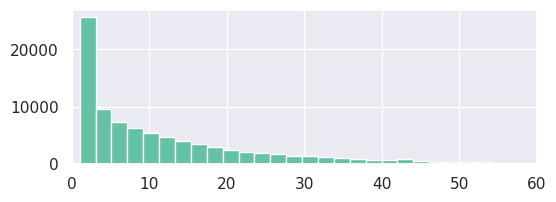

In [199]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
plt.xlim(0, 60)
mrg_mean_ratings_beer_df['count'].hist(bins=160)
plt.show()

In [200]:
def filter_by_review_count(df, n):
    filtered_df = df[df['count'] > n]
    states_with_multiple_entries = filtered_df['state'].value_counts()
    states_to_keep = states_with_multiple_entries[states_with_multiple_entries > 1].index
    filtered_df = filtered_df[filtered_df['state'].isin(states_to_keep)]
    return filtered_df

# Example usage:
mrg_mean_ratings_c10_beer_df = filter_by_review_count(mrg_mean_ratings_beer_df, 10)
mrg_mean_ratings_c10_beer_df.tail()



state date_object  mean_rating  count  median_tmax
88008  Wisconsin  2017-06-18     3.975000     12         82.0
88029  Wisconsin  2017-07-09     4.096111     18         79.5
88513    Wyoming  2014-04-26     3.300500     20         51.0
88514    Wyoming  2014-04-27     3.314970    169         41.0
88809    Wyoming  2015-09-30     4.159677     31         76.0

### Compute Pearson correlation

In [201]:
from scipy.stats import pearsonr
corr_mean_ratings = mrg_mean_ratings_beer_df.groupby('state').apply(lambda x: pd.Series(pearsonr(x['mean_rating'], x['median_tmax']), index=['correlation', 'p_value']), include_groups=False)
corr_mean_ratings['count'] = mrg_mean_ratings_beer_df.groupby('state')['mean_rating'].count().values
corr_mean_ratings.reset_index(inplace=True)
corr_ratings = mrg_ratings_beer_df.groupby('state').apply(lambda x: pd.Series(pearsonr(x['rating'], x['median_tmax']), index=['correlation', 'p_value']), include_groups=False)
corr_ratings['count'] = mrg_ratings_beer_df.groupby('state')['rating'].count().values
corr_ratings.reset_index(inplace=True)
corr_mean_ratings_c10 = mrg_mean_ratings_c10_beer_df.groupby('state').apply(lambda x: pd.Series(pearsonr(x['mean_rating'], x['median_tmax']), index=['correlation', 'p_value']), include_groups=False)
corr_mean_ratings_c10.reset_index(inplace=True)
corr_mean_ratings_c5 = filter_by_review_count(mrg_mean_ratings_beer_df, 5).groupby('state').apply(lambda x: pd.Series(pearsonr(x['mean_rating'], x['median_tmax']), index=['correlation', 'p_value']), include_groups=False)
corr_mean_ratings_c5.reset_index(inplace=True)
corr_mean_rating_c20 = filter_by_review_count(mrg_mean_ratings_beer_df, 20).groupby('state').apply(lambda x: pd.Series(pearsonr(x['mean_rating'], x['median_tmax']), index=['correlation', 'p_value']), include_groups=False)
corr_mean_rating_c20.reset_index(inplace=True)

In [202]:
corr_ratings

state  correlation       p_value   count
0          Alabama     0.015116  2.348423e-01    6178
1           Alaska     0.030384  2.800283e-01    1266
2          Arizona    -0.010089  2.868047e-01   11149
3         Arkansas    -0.013883  3.838318e-01    3937
4       California    -0.014972  1.807662e-06  101659
5         Colorado    -0.015841  1.916622e-03   38363
6      Connecticut    -0.047089  1.661887e-10   18395
7          Florida    -0.020588  1.338619e-04   34410
8          Georgia     0.008793  1.542484e-01   26254
9            Idaho     0.119646  1.316180e-25    7591
10        Illinois    -0.013736  7.303021e-05   83365
11         Indiana    -0.013366  4.826069e-02   21837
12            Iowa    -0.007945  4.563157e-01    8793
13          Kansas    -0.045074  5.926483e-03    3726
14        Kentucky    -0.027964  4.817268e-02    4993
15       Louisiana    -0.002450  8.135287e-01    9270
16           Maine    -0.018047  7.637696e-02    9643
17        Maryland    -0.018461  1.106613e-03   31217
18   Massachusetts    -0.013469  2.504984e-04   73908
19        Michigan    -0.012921  1.566969e-02   34977
20       Minnesota    -0.002201  6.671720e-01   38187
21     Mississippi     0.001191  9.380029e-01    4266
22        Missouri    -0.030619  6.186046e-06   21783
23         Montana    -0.012398  5.717950e-01    2082
24        Nebraska    -0.012700  3.856115e-01    4669
25          Nevada     0.069796  1.511829e-07    5649
26   New Hampshire    -0.042596  3.644668e-03    4657
27      New Jersey    -0.015550  1.974989e-03   39587
28      New Mexico    -0.038161  7.356090e-03    4932
29        New York    -0.030347  8.166674e-20   90095
30  North Carolina    -0.014433  9.384045e-03   32395
31    North Dakota     0.041218  5.048871e-01     264
32            Ohio    -0.017052  1.101773e-04   51422
33        Oklahoma    -0.024645  6.168865e-02    5749
34          Oregon    -0.014065  4.647073e-02   20040
35    Pennsylvania    -0.018618  1.255071e-09  106381
36  South Carolina    -0.027015  2.561398e-04   18311
37    South Dakota     0.074400  3.469703e-02     806
38       Tennessee    -0.033655  1.747158e-03    8648
39           Texas    -0.024940  1.299491e-07   44790
40            Utah     0.019336  5.140877e-01    1141
41        Virginia    -0.010759  2.293016e-02   44692
42      Washington    -0.004699  2.874709e-01   51237
43   West Virginia    -0.026030  6.455094e-02    5043
44       Wisconsin    -0.007480  2.608421e-01   22600
45         Wyoming     0.022855  2.943664e-01    2107

In [203]:
corr_mean_rating_c20

state  correlation       p_value
0          Alabama     0.313477  5.451872e-01
1           Alaska    -1.000000  1.000000e+00
2          Arizona    -0.045607  8.485835e-01
3         Arkansas    -0.853553  3.488867e-01
4       California    -0.047898  2.639182e-02
5         Colorado    -0.023877  5.826503e-01
6      Connecticut    -0.313798  1.551054e-02
7          Florida    -0.080884  9.391288e-02
8          Georgia     0.079792  2.883471e-01
9            Idaho     0.486110  1.099258e-03
10        Illinois    -0.076153  8.991395e-04
11         Indiana     0.006245  9.393417e-01
12            Iowa    -0.583148  1.291920e-01
13        Kentucky    -0.370474  2.620450e-01
14       Louisiana    -0.243077  5.994219e-01
15           Maine    -0.258189  3.170416e-01
16        Maryland    -0.053647  3.183301e-01
17   Massachusetts    -0.048262  3.512864e-02
18        Michigan    -0.022866  6.312373e-01
19       Minnesota     0.077353  5.580282e-02
20     Mississippi     0.648293  3.517071e-01
21        Missouri    -0.064966  4.789714e-01
22         Montana    -1.000000  1.000000e+00
23        Nebraska     0.400998  7.373270e-01
24          Nevada     0.029579  8.702010e-01
25   New Hampshire     0.712244  2.877558e-01
26      New Jersey    -0.071714  7.531116e-02
27        New York    -0.134623  1.722437e-10
28  North Carolina    -0.040031  4.978621e-01
29            Ohio    -0.062874  4.586046e-02
30          Oregon    -0.041453  6.628824e-01
31    Pennsylvania    -0.088406  2.223521e-05
32  South Carolina    -0.259313  2.898198e-02
33       Tennessee     0.643672  3.563281e-01
34           Texas    -0.155007  7.928277e-06
35        Virginia    -0.015699  6.521204e-01
36      Washington    -0.009899  7.482052e-01
37       Wisconsin     0.177888  9.729102e-02
38         Wyoming     1.000000  1.000000e+00

In [204]:
merged_corr_df = corr_mean_ratings.merge(corr_ratings, on='state', suffixes=('_mean_rating', '_rating'))
merged_corr_df.rename(columns={
    'correlation_mean_rating': 'correlation_mean_rating',
    'p_value_mean_rating': 'p_value_mean_rating',
    'correlation_rating': 'correlation_rating',
    'p_value_rating': 'p_value_rating'
}, inplace=True)
merged_corr_df = merged_corr_df[['state', 'correlation_mean_rating', 'correlation_rating', 'p_value_mean_rating', 'p_value_rating']]

merged_corr_df = merged_corr_df.merge(corr_mean_ratings_c10, on='state', suffixes=('', '_mean_rating_c10'))
merged_corr_df.rename(columns={
    'correlation': 'correlation_mean_rating_c10',
    'p_value': 'p_value_mean_rating_c10'
}, inplace=True)
merged_corr_df = merged_corr_df[['state','correlation_rating', 'correlation_mean_rating', 'correlation_mean_rating_c10', 'p_value_rating', 'p_value_mean_rating', 'p_value_mean_rating_c10']]

In [205]:
merged_corr_df

state  correlation_rating  correlation_mean_rating  \
0          Alabama            0.015116                -0.013385   
1           Alaska            0.030384                 0.039258   
2          Arizona           -0.010089                 0.017172   
3         Arkansas           -0.013883                 0.007338   
4       California           -0.014972                -0.035199   
5         Colorado           -0.015841                -0.057885   
6      Connecticut           -0.047089                -0.106328   
7          Florida           -0.020588                -0.046699   
8          Georgia            0.008793                 0.031015   
9            Idaho            0.119646                 0.048909   
10        Illinois           -0.013736                -0.062101   
11         Indiana           -0.013366                -0.029562   
12            Iowa           -0.007945                 0.015348   
13          Kansas           -0.045074                -0.058228   
14        Kentucky           -0.027964                -0.066858   
15       Louisiana           -0.002450                 0.014629   
16           Maine           -0.018047                -0.044080   
17        Maryland           -0.018461                -0.040368   
18   Massachusetts           -0.013469                -0.047940   
19        Michigan           -0.012921                -0.051139   
20       Minnesota           -0.002201                -0.048312   
21     Mississippi            0.001191                -0.003020   
22        Missouri           -0.030619                -0.059949   
23         Montana           -0.012398                -0.005696   
24        Nebraska           -0.012700                -0.012210   
25          Nevada            0.069796                 0.046858   
26   New Hampshire           -0.042596                -0.117144   
27      New Jersey           -0.015550                -0.056327   
28      New Mexico           -0.038161                -0.046913   
29        New York           -0.030347                -0.129857   
30  North Carolina           -0.014433                -0.070705   
31            Ohio           -0.017052                -0.075987   
32        Oklahoma           -0.024645                -0.032372   
33          Oregon           -0.014065                -0.026163   
34    Pennsylvania           -0.018618                -0.083324   
35  South Carolina           -0.027015                -0.071511   
36    South Dakota            0.074400                 0.078971   
37       Tennessee           -0.033655                -0.047785   
38           Texas           -0.024940                -0.045364   
39            Utah            0.019336                 0.012338   
40        Virginia           -0.010759                -0.045211   
41      Washington           -0.004699                -0.033993   
42   West Virginia           -0.026030                -0.055614   
43       Wisconsin           -0.007480                -0.032434   
44         Wyoming            0.022855                -0.049049   

    correlation_mean_rating_c10  p_value_rating  p_value_mean_rating  \
0                      0.194813    2.348423e-01         5.572689e-01   
1                     -0.729136    2.800283e-01         2.787850e-01   
2                     -0.228065    2.868047e-01         4.083788e-01   
3                     -0.556540    3.838318e-01         7.520076e-01   
4                     -0.042223    1.807662e-06         8.444254e-02   
5                     -0.065127    1.916622e-03         4.550371e-03   
6                     -0.107361    1.661887e-10         8.886303e-07   
7                     -0.073899    1.338619e-04         2.209137e-02   
8                     -0.020397    1.542484e-01         1.288412e-01   
9                      0.299585    1.316180e-25         4.031951e-02   
10                    -0.066760    7.303021e-05         2.322376e-03   
11                    -0.073653    4.826069e-02         1.492044e-

In [206]:
merged_corr_df.shape[0]

45

In [207]:
corr_mean_ratings[corr_mean_ratings['p_value'] <= 0.05]

state  correlation       p_value  count
5         Colorado    -0.057885  4.550371e-03   2401
6      Connecticut    -0.106328  8.886303e-07   2127
7          Florida    -0.046699  2.209137e-02   2402
9            Idaho     0.048909  4.031951e-02   1758
10        Illinois    -0.062101  2.322376e-03   2403
13          Kansas    -0.058228  2.315076e-02   1521
16           Maine    -0.044080  3.472157e-02   2295
17        Maryland    -0.040368  4.823239e-02   2395
18   Massachusetts    -0.047940  1.878847e-02   2402
19        Michigan    -0.051139  1.218756e-02   2402
20       Minnesota    -0.048312  1.788762e-02   2402
22        Missouri    -0.059949  3.553920e-03   2363
26   New Hampshire    -0.117144  2.635962e-03    657
27      New Jersey    -0.056327  5.756178e-03   2402
28      New Mexico    -0.046913  4.941485e-02   1755
29        New York    -0.129857  1.665406e-10   2403
30  North Carolina    -0.070705  5.233168e-04   2403
32            Ohio    -0.075987  1.927292e-04   2403
35    Pennsylvania    -0.083324  4.321460e-05   2403
36  South Carolina    -0.071511  4.650798e-04   2392
38       Tennessee    -0.047785  2.480754e-02   2206
39           Texas    -0.045364  2.613458e-02   2404
41        Virginia    -0.045211  2.670725e-02   2402
43   West Virginia    -0.055614  1.639291e-02   1862

In [208]:
corr_mean_ratings_c10[corr_mean_ratings_c10['p_value'] <= 0.05]

state  correlation       p_value
2          Arizona    -0.228065  6.338177e-03
4       California    -0.042223  3.918029e-02
5         Colorado    -0.065127  5.707731e-03
6      Connecticut    -0.107361  7.222448e-03
7          Florida    -0.073899  3.623917e-03
9            Idaho     0.299585  1.771649e-04
10        Illinois    -0.066760  1.160093e-03
11         Indiana    -0.073653  4.403560e-02
17        Maryland    -0.093728  6.757765e-04
18   Massachusetts    -0.052318  1.072075e-02
19        Michigan    -0.051784  4.890264e-02
22        Missouri    -0.082424  1.775133e-02
27      New Jersey    -0.064199  6.976065e-03
29        New York    -0.129816  1.793813e-10
30  North Carolina    -0.090326  3.435379e-04
31            Ohio    -0.071609  1.141413e-03
34    Pennsylvania    -0.083187  4.531197e-05
35  South Carolina    -0.089822  4.968984e-02
38           Texas    -0.077245  8.125892e-04

In [209]:
corr_mean_rating_c20[corr_mean_ratings_c10['p_value'] <= 0.05]

/tmp/ipykernel_70771/765007592.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



state  correlation       p_value
2         Arizona    -0.045607  8.485835e-01
4      California    -0.047898  2.639182e-02
5        Colorado    -0.023877  5.826503e-01
6     Connecticut    -0.313798  1.551054e-02
7         Florida    -0.080884  9.391288e-02
9           Idaho     0.486110  1.099258e-03
10       Illinois    -0.076153  8.991395e-04
11        Indiana     0.006245  9.393417e-01
17  Massachusetts    -0.048262  3.512864e-02
18       Michigan    -0.022866  6.312373e-01
19      Minnesota     0.077353  5.580282e-02
22        Montana    -1.000000  1.000000e+00
27       New York    -0.134623  1.722437e-10
29           Ohio    -0.062874  4.586046e-02
30         Oregon    -0.041453  6.628824e-01
31   Pennsylvania    -0.088406  2.223521e-05
34          Texas    -0.155007  7.928277e-06
35       Virginia    -0.015699  6.521204e-01
38        Wyoming     1.000000  1.000000e+00

In [210]:
import plotly.express as px
from src.utils.preProcessingHelper import merge_with_states 

fig = px.choropleth(merge_with_states(corr_mean_ratings[corr_mean_ratings['p_value'] <= 0.05]), 
                    locations='abbreviation', 
                    locationmode='USA-states', 
                    color='correlation', 
                    color_continuous_scale="RdBu",
                    color_continuous_midpoint=0,
                    # color_continuous_scale="Viridis",
                    scope="usa",
                    title='Significant Correlations by State')
fig.show()

fig = px.choropleth(merge_with_states(corr_mean_ratings_c10[corr_mean_ratings_c10['p_value'] <= 0.05]), 
                    locations='abbreviation', 
                    locationmode='USA-states', 
                    color='correlation', 
                    color_continuous_scale="RdBu",
                    color_continuous_midpoint=0,
                    # color_continuous_scale="Viridis",
                    scope="usa",
                    title='Significant Correlations by State')
fig.show()

fig = px.choropleth(merge_with_states(corr_mean_ratings_c5[corr_mean_ratings_c5['p_value'] <= 0.05]), 
                    locations='abbreviation', 
                    locationmode='USA-states', 
                    color='correlation', 
                    color_continuous_scale="RdBu",
                    color_continuous_midpoint=0,
                    # color_continuous_scale="Viridis",
                    scope="usa",
                    title='Significant Correlations by State')
fig.show()

In [211]:
merge_with_states(corr_mean_ratings[corr_mean_ratings['p_value'] <= 0.05])

state  correlation       p_value  count abbreviation
0         Colorado    -0.057885  4.550371e-03   2401           CO
1      Connecticut    -0.106328  8.886303e-07   2127           CT
2          Florida    -0.046699  2.209137e-02   2402           FL
3            Idaho     0.048909  4.031951e-02   1758           ID
4         Illinois    -0.062101  2.322376e-03   2403           IL
5           Kansas    -0.058228  2.315076e-02   1521           KS
6            Maine    -0.044080  3.472157e-02   2295           ME
7         Maryland    -0.040368  4.823239e-02   2395           MD
8    Massachusetts    -0.047940  1.878847e-02   2402           MA
9         Michigan    -0.051139  1.218756e-02   2402           MI
10       Minnesota    -0.048312  1.788762e-02   2402           MN
11        Missouri    -0.059949  3.553920e-03   2363           MO
12   New Hampshire    -0.117144  2.635962e-03    657           NH
13      New Jersey    -0.056327  5.756178e-03   2402           NJ
14      New Mexico    -0.046913  4.941485e-02   1755           NM
15        New York    -0.129857  1.665406e-10   2403           NY
16  North Carolina    -0.070705  5.233168e-04   2403           NC
17            Ohio    -0.075987  1.927292e-04   2403           OH
18    Pennsylvania    -0.083324  4.321460e-05   2403           PA
19  South Carolina    -0.071511  4.650798e-04   2392           SC
20       Tennessee    -0.047785  2.480754e-02   2206           TN
21           Texas    -0.045364  2.613458e-02   2404           TX
22        Virginia    -0.045211  2.670725e-02   2402           VA
23   West Virginia    -0.055614  1.639291e-02   1862           WV

In [212]:
corr_mean_ratings

state  correlation       p_value  count
0          Alabama    -0.013385  5.572689e-01   1925
1           Alaska     0.039258  2.787850e-01    763
2          Arizona     0.017172  4.083788e-01   2320
3         Arkansas     0.007338  7.520076e-01   1857
4       California    -0.035199  8.444254e-02   2404
5         Colorado    -0.057885  4.550371e-03   2401
6      Connecticut    -0.106328  8.886303e-07   2127
7          Florida    -0.046699  2.209137e-02   2402
8          Georgia     0.031015  1.288412e-01   2399
9            Idaho     0.048909  4.031951e-02   1758
10        Illinois    -0.062101  2.322376e-03   2403
11         Indiana    -0.029562  1.492044e-01   2382
12            Iowa     0.015348  4.817777e-01   2103
13          Kansas    -0.058228  2.315076e-02   1521
14        Kentucky    -0.066858  7.359387e-02    717
15       Louisiana     0.014629  4.895167e-01   2234
16           Maine    -0.044080  3.472157e-02   2295
17        Maryland    -0.040368  4.823239e-02   2395
18   Massachusetts    -0.047940  1.878847e-02   2402
19        Michigan    -0.051139  1.218756e-02   2402
20       Minnesota    -0.048312  1.788762e-02   2402
21     Mississippi    -0.003020  9.028082e-01   1637
22        Missouri    -0.059949  3.553920e-03   2363
23         Montana    -0.005696  8.486449e-01   1125
24        Nebraska    -0.012210  6.181676e-01   1669
25          Nevada     0.046858  7.239534e-02   1471
26   New Hampshire    -0.117144  2.635962e-03    657
27      New Jersey    -0.056327  5.756178e-03   2402
28      New Mexico    -0.046913  4.941485e-02   1755
29        New York    -0.129857  1.665406e-10   2403
30  North Carolina    -0.070705  5.233168e-04   2403
31    North Dakota     0.123803  1.223936e-01    157
32            Ohio    -0.075987  1.927292e-04   2403
33        Oklahoma    -0.032372  1.508216e-01   1971
34          Oregon    -0.026163  2.027481e-01   2372
35    Pennsylvania    -0.083324  4.321460e-05   2403
36  South Carolina    -0.071511  4.650798e-04   2392
37    South Dakota     0.078971  1.180549e-01    393
38       Tennessee    -0.047785  2.480754e-02   2206
39           Texas    -0.045364  2.613458e-02   2404
40            Utah     0.012338  7.288358e-01    792
41        Virginia    -0.045211  2.670725e-02   2402
42      Washington    -0.033993  9.579155e-02   2402
43   West Virginia    -0.055614  1.639291e-02   1862
44       Wisconsin    -0.032434  1.126220e-01   2394
45         Wyoming    -0.049049  1.005639e-01   1122

In [213]:
merge_with_states(corr_mean_ratings[corr_mean_ratings['p_value'] <= 0.05])

state  correlation       p_value  count abbreviation
0         Colorado    -0.057885  4.550371e-03   2401           CO
1      Connecticut    -0.106328  8.886303e-07   2127           CT
2          Florida    -0.046699  2.209137e-02   2402           FL
3            Idaho     0.048909  4.031951e-02   1758           ID
4         Illinois    -0.062101  2.322376e-03   2403           IL
5           Kansas    -0.058228  2.315076e-02   1521           KS
6            Maine    -0.044080  3.472157e-02   2295           ME
7         Maryland    -0.040368  4.823239e-02   2395           MD
8    Massachusetts    -0.047940  1.878847e-02   2402           MA
9         Michigan    -0.051139  1.218756e-02   2402           MI
10       Minnesota    -0.048312  1.788762e-02   2402           MN
11        Missouri    -0.059949  3.553920e-03   2363           MO
12   New Hampshire    -0.117144  2.635962e-03    657           NH
13      New Jersey    -0.056327  5.756178e-03   2402           NJ
14      New Mexico    -0.046913  4.941485e-02   1755           NM
15        New York    -0.129857  1.665406e-10   2403           NY
16  North Carolina    -0.070705  5.233168e-04   2403           NC
17            Ohio    -0.075987  1.927292e-04   2403           OH
18    Pennsylvania    -0.083324  4.321460e-05   2403           PA
19  South Carolina    -0.071511  4.650798e-04   2392           SC
20       Tennessee    -0.047785  2.480754e-02   2206           TN
21           Texas    -0.045364  2.613458e-02   2404           TX
22        Virginia    -0.045211  2.670725e-02   2402           VA
23   West Virginia    -0.055614  1.639291e-02   1862           WV

In [214]:
import plotly.express as px
from src.utils.preProcessingHelper import merge_with_states 

hover_data = {
    'state': True,
    'correlation': ':.2f',
    'p_value': ':.2e',
    'abbreviation': False,
    'count': True
}


fig = px.choropleth(merge_with_states(corr_mean_ratings[corr_mean_ratings['p_value'] <= 0.05]), 
                    locations='abbreviation', 
                    locationmode='USA-states', 
                    color='correlation',
                    hover_data=hover_data,
                    color_continuous_scale="RdBu",
                    color_continuous_midpoint=0,
                    scope="usa")
fig.show()

In [215]:
mrg_mean_ratings_c10_beer_df[mrg_mean_ratings_c10_beer_df['state'] == 'Idaho']

state date_object  mean_rating  count  median_tmax
18636  Idaho  2011-02-22     3.820000     11         31.0
18649  Idaho  2011-03-07     3.663846     13         37.0
18685  Idaho  2011-04-16     3.779091     11         57.0
18711  Idaho  2011-05-21     3.758182     11         64.0
18782  Idaho  2011-08-20     3.707500     16         87.0
...      ...         ...          ...    ...          ...
20310  Idaho  2017-06-06     3.891667     12         83.0
20311  Idaho  2017-06-07     2.884000     20         87.0
20314  Idaho  2017-06-10     3.701154     26         60.0
20315  Idaho  2017-06-11     3.180909     22         64.0
20318  Idaho  2017-06-14     3.661176     17         67.0

[152 rows x 5 columns]

In [216]:

df = mrg_mean_ratings_beer_df[mrg_mean_ratings_beer_df['date_object'].str.startswith(('2017', '2016', '2018'))].copy()
corr_mean_ratings_2016 = df.groupby('state').apply(lambda x: pd.Series(pearsonr(x['mean_rating'], x['median_tmax']), index=['correlation', 'p_value']), include_groups=False)
corr_mean_ratings_2016['count'] = df.groupby('state')['mean_rating'].count().values
corr_mean_ratings_2016.reset_index(inplace=True)
corr_mean_ratings_2016

state  correlation       p_value  count
0          Alabama     0.023034  6.523189e-01    385
1           Alaska     0.032374  7.103834e-01    134
2          Arizona    -0.057046  1.772581e-01    561
3         Arkansas    -0.036837  4.069189e-01    509
4       California     0.022592  5.874638e-01    579
5         Colorado    -0.013637  7.439699e-01    576
6      Connecticut    -0.126137  3.097831e-03    548
7          Florida    -0.046638  2.633729e-01    577
8          Georgia     0.094291  2.387383e-02    574
9            Idaho     0.126115  7.394002e-03    450
10        Illinois    -0.077703  6.191662e-02    578
11         Indiana    -0.096074  2.155966e-02    572
12            Iowa     0.070860  9.537739e-02    555
13          Kansas    -0.118156  3.405478e-02    322
14        Kentucky    -0.057082  1.750584e-01    566
15       Louisiana     0.123761  4.749647e-03    519
16           Maine    -0.104161  1.435170e-02    552
17        Maryland    -0.004163  9.209399e-01    571
18   Massachusetts    -0.068956  9.797568e-02    577
19        Michigan    -0.082188  4.826899e-02    578
20       Minnesota    -0.044770  2.829967e-01    577
21     Mississippi    -0.026328  5.762241e-01    453
22        Missouri    -0.041322  3.247151e-01    570
23         Montana     0.092031  1.069654e-01    308
24        Nebraska    -0.048565  3.828527e-01    325
25          Nevada     0.092180  4.138786e-02    490
26      New Jersey    -0.001144  9.781221e-01    577
27      New Mexico     0.007897  8.893212e-01    313
28        New York    -0.264958  9.655019e-11    578
29  North Carolina    -0.062931  1.307434e-01    578
30    North Dakota    -0.053152  7.923176e-01     27
31            Ohio    -0.071492  8.593032e-02    578
32        Oklahoma     0.002395  9.590622e-01    462
33          Oregon    -0.065058  1.268446e-01    552
34    Pennsylvania    -0.067541  1.047755e-01    578
35  South Carolina    -0.144757  4.977724e-04    575
36    South Dakota     0.080289  3.714782e-01    126
37       Tennessee    -0.070143  1.060853e-01    532
38           Texas    -0.039822  3.388039e-01    579
39            Utah     0.040089  5.983775e-01    175
40        Virginia    -0.101980  1.425683e-02    577
41      Washington    -0.041895  3.150845e-01    577
42   West Virginia    -0.113213  2.251952e-02    406
43       Wisconsin    -0.121577  3.618967e-03    571
44         Wyoming    -0.056257  3.219339e-01    312

In [217]:
import plotly.express as px
from src.utils.preProcessingHelper import merge_with_states 

hover_data = {
    'state': True,
    'correlation': ':.2f',
    'p_value': ':.2e'
}


fig = px.choropleth(merge_with_states(corr_mean_ratings_2016[corr_mean_ratings_2016['p_value'] <= 0.05]), 
                    locations='abbreviation', 
                    locationmode='USA-states', 
                    color='correlation',
                    hover_data=hover_data,
                    color_continuous_scale="RdBu",
                    color_continuous_midpoint=0,
                    scope="usa")
fig.show()

# 6. <a id='toc6_'></a>[Conclusion](#toc0_)

In this data analyais we started wih.....